## 数据分析可视化

In [1]:
%matplotlib inline
import os
import tqdm
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import math
from scipy.stats import norm, skew #for some statistics
import pandas_profiling as ppf # 探索性数据分析(EDA)
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 可视化

In [2]:
path ='./train_set/'
data = pd.read_csv(path+'train_143201.csv')
data.columns = ['Cell_Index','Cell_X','Cell_Y','Height','Azimuth','Electrical_Downtilt',
                'Mechanical_Downtilt','Frequency_Band','RS_Power','Cell_Altitude',
                'Cell_Building_Height','Cell_Clutter_Index','X','Y','Altitude','Building_Height','Clutter_Index','RSRP']

In [3]:
# 分类数据和数值数据的划分
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('RSRP')
quantitative.remove('Cell_Index')
quantitative.remove('Cell_X')
quantitative.remove('Cell_Y')
quantitative.remove('X')
quantitative.remove('Y')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

In [4]:
data.head(n=5)

,Cell_Index,Cell_X,Cell_Y,Height,Azimuth,Electrical_Downtilt,Mechanical_Downtilt,Frequency_Band,RS_Power,Cell_Altitude,Cell_Building_Height,Cell_Clutter_Index,X,Y,Altitude,Building_Height,Clutter_Index,RSRP
0,143201,413475.0,3388395.0,25,250,6,0,2585.0,14.2,488,0,5,413600,3388495,491,18,12,-119.5
1,143201,413475.0,3388395.0,25,250,6,0,2585.0,14.2,488,0,5,413610,3388485,490,0,14,-107.0
2,143201,413475.0,3388395.0,25,250,6,0,2585.0,14.2,488,0,5,413435,3388250,490,0,5,-100.5
3,143201,413475.0,3388395.0,25,250,6,0,2585.0,14.2,488,0,5,413420,3388255,489,0,5,-94.0
4,143201,413475.0,3388395.0,25,250,6,0,2585.0,14.2,488,0,5,413280,3388235,490,6,5,-87.5


P-P图是根据变量的累积概率对应于所指定的理论分布累积概率绘制的散点图，用于直观地检测样本数据是否符合某一概率分布。如果被检验的数据符合所指定的分布，则代表样本数据的点应当基本在代表理论分布的对角线上。
       由于P-P图和Q-Q图的用途完全相同，只是检验方法存在差异。要利用QQ图鉴别样本数据是否近似于正态分布,只需看QQ图上的点是否近似地在一条直线附近,而且该直线的斜率为标准差,截距为均值.
用QQ图还可获得样本偏度和峰度的粗略信息

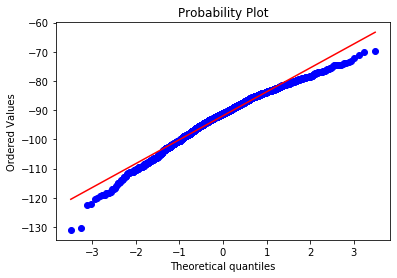

In [5]:
fig = plt.figure()
res = stats.probplot(data['RSRP'], plot=plt)
plt.show()

In [6]:
data['RSRP'].describe()

count    2876.000000
mean      -91.912712
std         8.267977
min      -131.000000
25%       -97.000000
50%       -91.120000
75%       -85.655000
max       -69.630000
Name: RSRP, dtype: float64

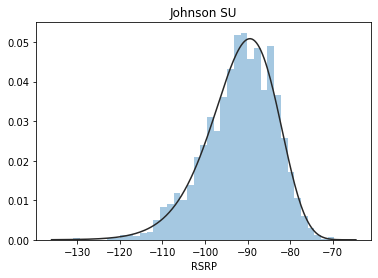

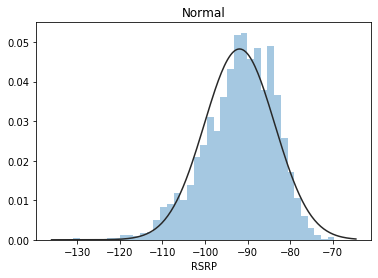

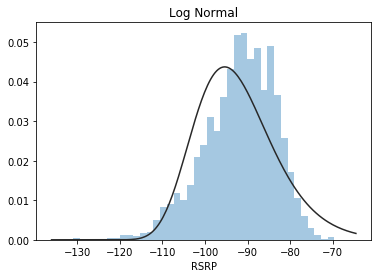

In [7]:
import scipy.stats as st
y = data['RSRP']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

In [8]:
print("Skewness: %f" % data['RSRP'].skew())
print("Kurtosis: %f" % data['RSRP'].kurt())

Skewness: -0.580214
Kurtosis: 0.397169


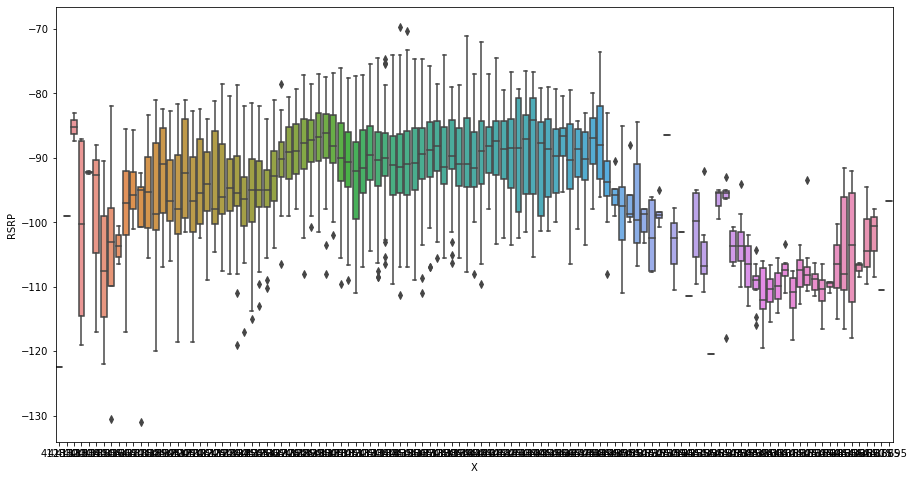

In [9]:
plt.figure(figsize=(15,8))
sns.boxplot(data.X, data.RSRP)

In [10]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(data[quantitative]) 
normal = normal.apply(test_normality)
print(not normal.any())

G:\anaconda\envs\tensorflow_gpu_nlp\lib\site-packages\scipy\stats\morestats.py:1657: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


False


In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'RSRP']].groupby(feature).mean()['RSRP']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

[]


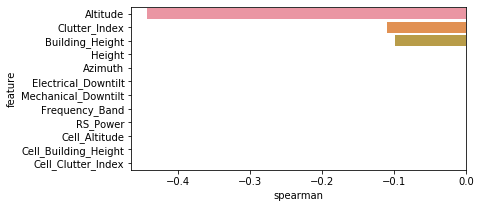

In [12]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['RSRP'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(data, features)

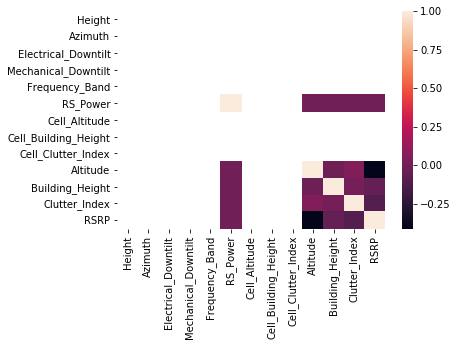

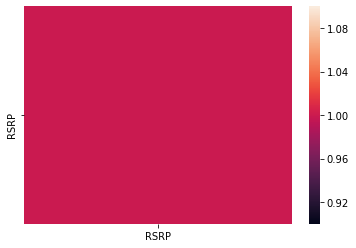

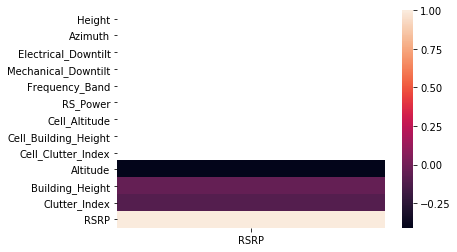

In [13]:
plt.figure(1)
corr = data[quantitative+['RSRP']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = data[qual_encoded+['RSRP']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['RSRP'], columns=qual_encoded+['RSRP'])
for q1 in quantitative+['RSRP']:
    for q2 in qual_encoded+['RSRP']:
        corr.loc[q1, q2] = data[q1].corr(data[q2])
sns.heatmap(corr)

G:\anaconda\envs\tensorflow_gpu_nlp\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


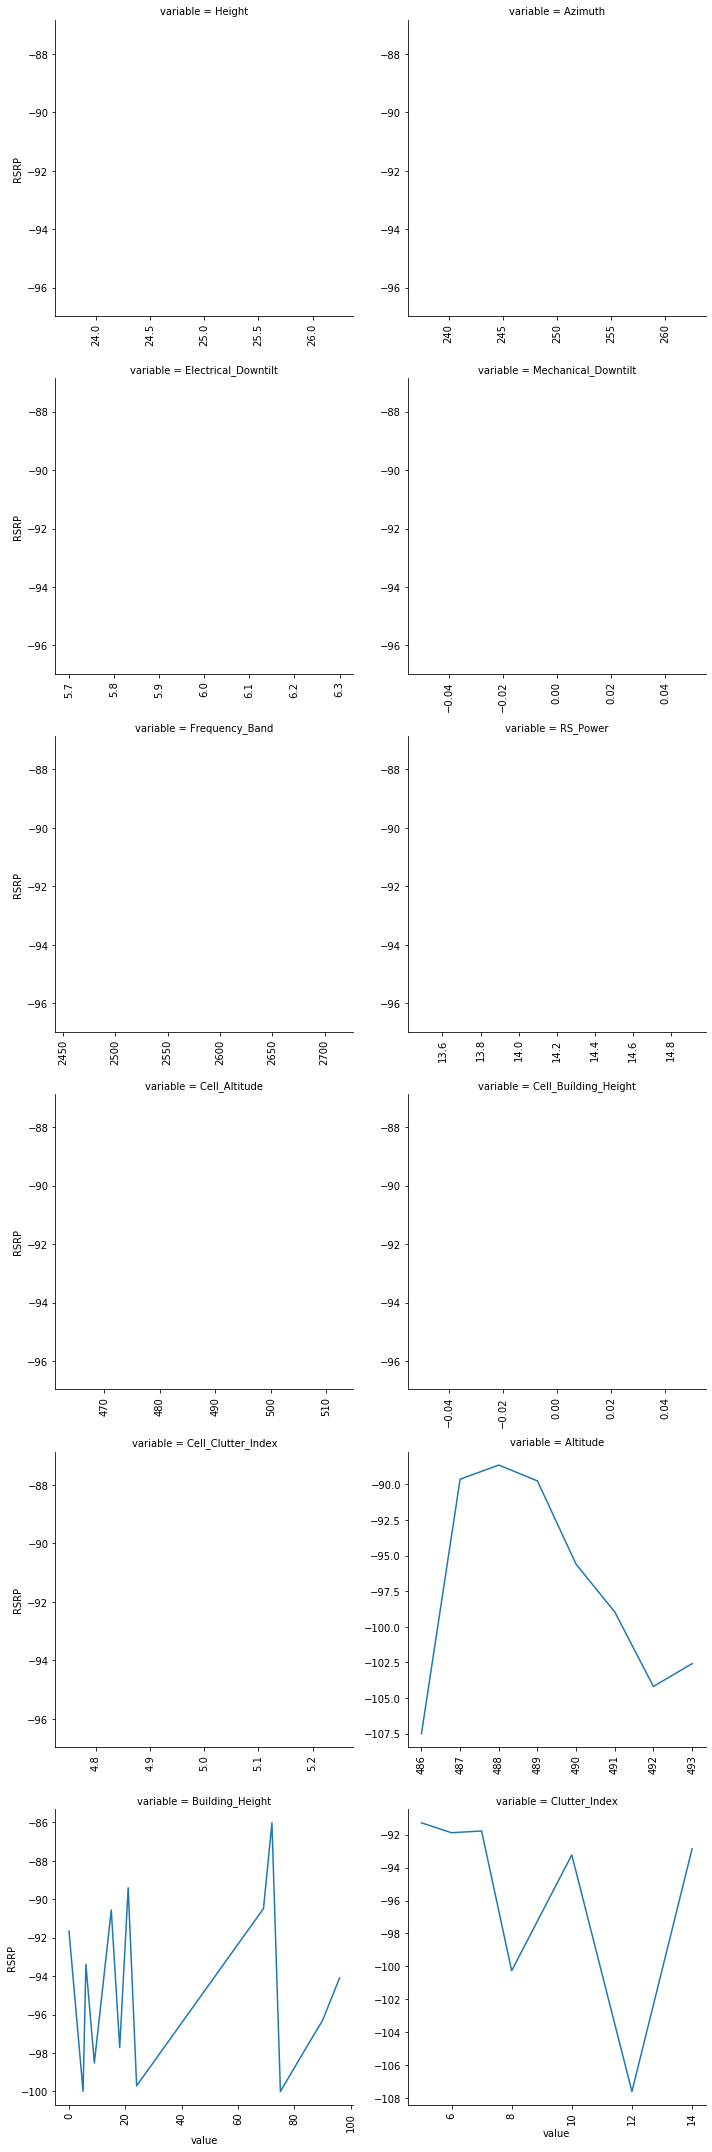

In [14]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(data, id_vars=['RSRP'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "RSRP")

## 数据处理

### 合并数据

In [ ]:
import os
import tqdm
import math
import pandas as pd
import numpy as np
import pandas_profiling as ppf # 探索性数据分析(EDA)
import matplotlib.pyplot as plt

In [ ]:
def get_imlist(path):   
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]

In [ ]:
path ='./train_set/'
pathlist = get_imlist(path)
train = pd.DataFrame()
for i in pathlist:
    train_tmp = pd.read_csv(i)
    train = pd.concat([train, train_tmp],axis=0,ignore_index=True) 

In [ ]:
train.columns = ['Cell_Index','Cell_X','Cell_Y','Height','Azimuth','Electrical_Downtilt',
                 'Mechanical_Downtilt','Frequency_Band','RS_Power','Cell_Altitude',
                 'Cell_Building_Height','Cell_Clutter_Index','X','Y','Altitude','Building_Height','Clutter_Index','RSRP']

In [ ]:
train.to_csv('train_data.csv',index=None)

## 特征制作

In [ ]:
data  = pd.read_csv('train_data.csv')
data.head(n=5)

In [ ]:
# palce0 开放区域
place0 = [1,2,3,7,19]
# palce1 郊区
place1 = [4,6,8,15,16,17,18]
# palce2 中小城市
place2 = [5,9,12,13,14]
# palce3 大城市
place3 = [10,11,20]
places = [place0,place1,place2,place3]
def citys(place,places):
    j = 0
    
    for i in (places):
        for t in i:
            if place == t:
                results = j
        j += 1
    return results
def alpha_parameter(t,f,hb0):
    
    if t == 0:
        alpha = (1.1*np.log10(f))*hb0-1.56*np.log10(f)-0.8
    elif t == 1:
        alpha = (1.1*np.log10(f))*hb0-1.56*np.log10(f)-0.8
    elif t == 2:
        alpha = (1.1*np.log10(f))*hb0-1.56*np.log10(f)-0.8
    elif t == 3:
        if f <=300:
            alpha = 8.29*(np.log10(abs(1.54*hb0)))**2 -1.1
        elif f>300:
            alpha = 3.2*(np.log10(abs(11.75*hb0)))**2 -4.97
        else:
            alpha = 80
    return alpha

def k_parameter(t,f):
    if t == 0:
        k = 2*(np.log10(f/28))**2 +5.4
    elif t == 1:
        k = 4.78*(np.log10(f))**2 -18.33*np.log10(f)+40.9
    elif t == 2:
        k = 0
    else:
        k = 0
    return k

In [ ]:
def geometric_fea(data,places):
    data['Relative_vertical_height'] = data.apply(lambda x: x['Height']+x['Cell_Altitude']-x['Altitude']-x['Building_Height']-1.5,axis=1)
    data['Relative_vertical_X'] = data.apply(lambda x: x['Cell_X']-x['X'],axis=1)
    data['Relative_vertical_Y'] = data.apply(lambda x: x['Cell_Y']-x['Y'],axis=1)
    # 目标栅格中心点与信号线的垂直距离  Hb- sqrt(l_tx**2+l_ty**2)*tan(垂直电下倾角+垂直机械下倾角)
    data['vt_distance'] = data.apply(lambda x: x['Relative_vertical_height'] - 
                                     np.sqrt(x['Relative_vertical_X']**2+x['Relative_vertical_Y']**2)*np.tan((x['Electrical_Downtilt']+x['Mechanical_Downtilt'])/180*math.pi),axis=1)
    #目标栅格中心点与信号源的距离 sqrt(Hb**2+l_tx**2+l_ty**2)
    data['line_distance']=data.apply(lambda x: np.sqrt(x['Relative_vertical_height']**2+ x['Relative_vertical_X']**2+x['Relative_vertical_Y']**2),axis=1) 
    data['slope_k'] = data.apply(lambda x: x['Relative_vertical_height']/np.sqrt(x['Relative_vertical_X']**2+x['Relative_vertical_Y']**2),axis = 1)
    data['distance'] = data.apply(lambda x: np.sqrt(x['Relative_vertical_X']**2+x['Relative_vertical_Y']**2),axis = 1)
    data['angle'] = data.apply(lambda x :(x['Electrical_Downtilt']+x['Mechanical_Downtilt'])/180*math.pi,axis=1)
    data['alpha'] = data.apply(lambda x:  alpha_parameter(citys(x['Clutter_Index'],places),x['Frequency_Band'],x['Relative_vertical_height']),axis=1)
    data['k'] = data.apply(lambda x:  k_parameter(citys(x['Clutter_Index'],places),x['Frequency_Band']),axis=1)
    data['Clutter_Index_new'] = data.apply(lambda x: citys(x['Clutter_Index'],places),axis=1)   
    return data  

In [ ]:
data = geometric_fea(data,places=places)

In [ ]:
data.to_csv('fea_all_train.csv',index=None)

## 模型数据处理

### 模型数据处理1

In [ ]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pickle import load
import numpy as np
from sklearn.model_selection import train_test_split
filename = 'fea_all_train.csv'
data = pd.read_csv(filename)
df_data_columns = [c for c in data.columns if c not in ['Cell_Index','Cell_X','Cell_Y','RSRP',
                                                        'X','Y','Clutter_Index','Electrical_Downtilt','Mechanical_Downtilt','Cell_Clutter_Index',]]

feature =  data[df_data_columns]
label = data[['RSRP']]
label = np.array(label.values)
feature = np.array(feature.values,dtype=np.float32)
imp = Imputer(missing_values='NaN', strategy='mean',axis=0, verbose=0, copy=True)
imp.fit(feature)
feature = imp.transform(feature)  

std = StandardScaler()
features = std.fit_transform(feature)
X_train, X_, y_train, y_ = train_test_split(feature,label,test_size=0.4, random_state=2018)
X_valid, X_test, y_valid, y_test = train_test_split(X_,y_,test_size=0.4, random_state=2018)





### 模型数据处理2

In [4]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pickle import load
import numpy as np
from sklearn.model_selection import train_test_split
filename = 'fea_all_train.csv'
data = pd.read_csv(filename)
df_data_columns = [c for c in data.columns if c not in ['Cell_Index','Cell_X','Cell_Y','k','Relative_vertical_Y','Relative_vertical_X',
                                                        'X','Y','Clutter_Index','RSRP','Height', 'Building_Height',
                                                        'Cell_Clutter_Index','Altitude',
                                                       'Cell_Building_Height', 'slope_k']]
feature =  data[df_data_columns]
label = data[['RSRP']]
X_train, X_, y_train, y_ = train_test_split(feature,label,test_size=0.4, random_state=2018)
X_valid, X_test, y_valid, y_test = train_test_split(X_,y_,test_size=0.4, random_state=2018)

### 相关性系数

In [ ]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pickle import load
import numpy as np
from sklearn.model_selection import train_test_split
filename = 'fea_all_train.csv'
data = pd.read_csv(filename)
df_data_columns = [c for c in data.columns if c not in [ 'Azimuth','Cell_Altitude','Cell_Building_Height','Building_Height',
                                                        'Relative_vertical_X','Relative_vertical_Y',
                                                        'Cell_Index','Cell_X','Cell_Y',
                                                        'X','Y','Clutter_Index','Electrical_Downtilt','Mechanical_Downtilt','Cell_Clutter_Index',]]


feature =  data[df_data_columns]
label = data[['RSRP']]
def de_mean(x):
    x_bar = np.mean(x)
    return [x_i - x_bar for x_i in x]
# 辅助计算函数 dot product 、sum_of_squares
def dot(v, w):
    return sum(v_i * w_i for v_i, w_i in zip(v, w))
def sum_of_squares(v):
    return dot(v, v)
# 方差
def variance(x):
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)
def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n -1)
def standard_deviation(x):
    return math.sqrt(variance(x))
def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0
    
a = ['Height', 'Frequency_Band', 'RS_Power', 'Altitude', 'RSRP',
       'Relative_vertical_height', 'vt_distance', 'line_distance', 'slope_k',
       'distance', 'angle', 'alpha', 'k', 'Clutter_Index_new']    

for i in a:
    print(correlation(data[i], data['RSRP']))

## 模型1

In [ ]:
def creat_model():
    x2_one = tf.keras.Input(shape=(18,))
    x2_in_one = tf.keras.layers.Dense(1024,activation='relu')(x2_one)
    x2_in_one = tf.reshape(x2_in_one,shape=[-1,1024,1])
    x2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding='same', activation='relu')(x2_in_one)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2) 
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2) 
    x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x = tf.keras.layers.Flatten()(x2) 
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.layers.Model(x2_one, x)
#    def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#    model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"])
    model.compile(loss='mean_squared_error',optimizer=Adam(),metrics =["accuracy"])
    model.summary()
    return model
import tf.keras
model = creat_model()
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.5, patience=2)
checkpoint = ModelCheckpoint('model_vector_one_news_tt_13_tf.hdf5', monitor='val_loss', 
                                 verbose=1, save_best_only=True, mode='min')
tf.keras.optimizers.SGD(lr=0.001, momentum=0.01, decay=0.001, nesterov=True)
hist = model.fit(X_train, y_train, batch_size=512, epochs=10,validation_data=(X_valid, y_valid),
          callbacks=[plateau,checkpoint], 
          verbose=1, shuffle=True) 

## 模型2

In [ ]:
def creat_model():
    x2_one = tf.keras.Input(shape=(13,))
    x2_in_one = tf.keras.layers.Dense(1024,activation='relu')(x2_one)
    x2_in_one = tf.reshape(x2_in_one,shape=[-1,1024,1])
    x2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding='same', activation='relu')(x2_in_one)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2) 
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2) 
    x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3,strides = 1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.2)(x2)
    x = tf.keras.layers.Flatten()(x2) 
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.layers.Model(x2_one, x)
#    def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#    model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"])
    model.compile(loss='mean_squared_error',optimizer=Adam(),metrics =["accuracy"])
    model.summary()
    return model

import tf.keras
model = creat_model()
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.5, patience=2)
checkpoint = ModelCheckpoint('model_vector_one_news_tt_13_tf.hdf5', monitor='val_loss', 
                                 verbose=1, save_best_only=True, mode='min')
tf.keras.optimizers.SGD(lr=0.001, momentum=0.01, decay=0.001, nesterov=True)
hist = model.fit(X_train, y_train, batch_size=512, epochs=10,validation_data=(X_valid, y_valid),
          callbacks=[plateau,checkpoint], 
          verbose=1, shuffle=True) 

## 模型3

In [19]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('Saving model...')
# save model to file
gbm.save_model('lgb.model3',num_iteration=gbm.best_iteration)

Starting training...
[1]	valid_0's l1: 8.4851	valid_0's l2: 112.777
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 8.41344	valid_0's l2: 110.984
[3]	valid_0's l1: 8.34801	valid_0's l2: 109.358
[4]	valid_0's l1: 8.28828	valid_0's l2: 107.893
[5]	valid_0's l1: 8.23406	valid_0's l2: 106.565
[6]	valid_0's l1: 8.18422	valid_0's l2: 105.352
[7]	valid_0's l1: 8.13869	valid_0's l2: 104.254
[8]	valid_0's l1: 8.09736	valid_0's l2: 103.259
[9]	valid_0's l1: 8.05937	valid_0's l2: 102.351
[10]	valid_0's l1: 8.02481	valid_0's l2: 101.53
[11]	valid_0's l1: 7.9934	valid_0's l2: 100.785
[12]	valid_0's l1: 7.96501	valid_0's l2: 100.111
[13]	valid_0's l1: 7.93858	valid_0's l2: 99.4916
[14]	valid_0's l1: 7.91451	valid_0's l2: 98.9252
[15]	valid_0's l1: 7.89231	valid_0's l2: 98.4075
[16]	valid_0's l1: 7.87237	valid_0's l2: 97.9442
[17]	valid_0's l1: 7.85385	valid_0's l2: 97.5151
[18]	valid_0's l1: 7.83694	valid_0's l2: 97.1222
[19]	valid_0's l1: 7.82127	valid_0's l2: 96.7607

[330]	valid_0's l1: 7.36513	valid_0's l2: 86.4753
[331]	valid_0's l1: 7.36471	valid_0's l2: 86.4655
[332]	valid_0's l1: 7.36412	valid_0's l2: 86.4519
[333]	valid_0's l1: 7.36374	valid_0's l2: 86.4428
[334]	valid_0's l1: 7.36318	valid_0's l2: 86.4311
[335]	valid_0's l1: 7.36273	valid_0's l2: 86.4212
[336]	valid_0's l1: 7.36214	valid_0's l2: 86.4085
[337]	valid_0's l1: 7.36169	valid_0's l2: 86.3991
[338]	valid_0's l1: 7.36046	valid_0's l2: 86.3694
[339]	valid_0's l1: 7.35979	valid_0's l2: 86.3558
[340]	valid_0's l1: 7.35877	valid_0's l2: 86.3329
[341]	valid_0's l1: 7.3583	valid_0's l2: 86.323
[342]	valid_0's l1: 7.35795	valid_0's l2: 86.3158
[343]	valid_0's l1: 7.35711	valid_0's l2: 86.2976
[344]	valid_0's l1: 7.35659	valid_0's l2: 86.2859
[345]	valid_0's l1: 7.35552	valid_0's l2: 86.2603
[346]	valid_0's l1: 7.35494	valid_0's l2: 86.2471
[347]	valid_0's l1: 7.35398	valid_0's l2: 86.2263
[348]	valid_0's l1: 7.35299	valid_0's l2: 86.2059
[349]	valid_0's l1: 7.35247	valid_0's l2: 86.1941
[3

[658]	valid_0's l1: 7.19226	valid_0's l2: 82.7728
[659]	valid_0's l1: 7.19193	valid_0's l2: 82.7656
[660]	valid_0's l1: 7.19114	valid_0's l2: 82.7495
[661]	valid_0's l1: 7.19101	valid_0's l2: 82.7465
[662]	valid_0's l1: 7.1903	valid_0's l2: 82.7307
[663]	valid_0's l1: 7.18996	valid_0's l2: 82.7236
[664]	valid_0's l1: 7.18934	valid_0's l2: 82.7122
[665]	valid_0's l1: 7.18918	valid_0's l2: 82.7086
[666]	valid_0's l1: 7.18853	valid_0's l2: 82.6947
[667]	valid_0's l1: 7.18843	valid_0's l2: 82.6928
[668]	valid_0's l1: 7.18816	valid_0's l2: 82.6879
[669]	valid_0's l1: 7.18761	valid_0's l2: 82.6755
[670]	valid_0's l1: 7.18712	valid_0's l2: 82.6648
[671]	valid_0's l1: 7.18662	valid_0's l2: 82.6546
[672]	valid_0's l1: 7.18639	valid_0's l2: 82.6495
[673]	valid_0's l1: 7.18553	valid_0's l2: 82.6314
[674]	valid_0's l1: 7.1854	valid_0's l2: 82.6292
[675]	valid_0's l1: 7.18495	valid_0's l2: 82.6196
[676]	valid_0's l1: 7.18479	valid_0's l2: 82.6165
[677]	valid_0's l1: 7.18468	valid_0's l2: 82.6143
[6

[986]	valid_0's l1: 7.07003	valid_0's l2: 80.2327
[987]	valid_0's l1: 7.06972	valid_0's l2: 80.2267
[988]	valid_0's l1: 7.0696	valid_0's l2: 80.224
[989]	valid_0's l1: 7.06927	valid_0's l2: 80.2176
[990]	valid_0's l1: 7.06911	valid_0's l2: 80.2145
[991]	valid_0's l1: 7.06867	valid_0's l2: 80.2057
[992]	valid_0's l1: 7.06849	valid_0's l2: 80.2018
[993]	valid_0's l1: 7.06808	valid_0's l2: 80.194
[994]	valid_0's l1: 7.06793	valid_0's l2: 80.1909
[995]	valid_0's l1: 7.06764	valid_0's l2: 80.185
[996]	valid_0's l1: 7.06744	valid_0's l2: 80.1809
[997]	valid_0's l1: 7.06711	valid_0's l2: 80.1749
[998]	valid_0's l1: 7.06682	valid_0's l2: 80.1687
[999]	valid_0's l1: 7.06662	valid_0's l2: 80.1651
[1000]	valid_0's l1: 7.06651	valid_0's l2: 80.1633
[1001]	valid_0's l1: 7.06589	valid_0's l2: 80.15
[1002]	valid_0's l1: 7.0654	valid_0's l2: 80.1396
[1003]	valid_0's l1: 7.06516	valid_0's l2: 80.1345
[1004]	valid_0's l1: 7.06507	valid_0's l2: 80.1323
[1005]	valid_0's l1: 7.06467	valid_0's l2: 80.1236
[

[1308]	valid_0's l1: 6.98165	valid_0's l2: 78.4564
[1309]	valid_0's l1: 6.98104	valid_0's l2: 78.4435
[1310]	valid_0's l1: 6.98088	valid_0's l2: 78.4403
[1311]	valid_0's l1: 6.98079	valid_0's l2: 78.4386
[1312]	valid_0's l1: 6.98045	valid_0's l2: 78.4321
[1313]	valid_0's l1: 6.98027	valid_0's l2: 78.4281
[1314]	valid_0's l1: 6.98013	valid_0's l2: 78.4249
[1315]	valid_0's l1: 6.98	valid_0's l2: 78.4227
[1316]	valid_0's l1: 6.97959	valid_0's l2: 78.4139
[1317]	valid_0's l1: 6.9794	valid_0's l2: 78.4099
[1318]	valid_0's l1: 6.97919	valid_0's l2: 78.4054
[1319]	valid_0's l1: 6.97895	valid_0's l2: 78.4006
[1320]	valid_0's l1: 6.97871	valid_0's l2: 78.3958
[1321]	valid_0's l1: 6.97864	valid_0's l2: 78.3944
[1322]	valid_0's l1: 6.97846	valid_0's l2: 78.3909
[1323]	valid_0's l1: 6.9784	valid_0's l2: 78.3897
[1324]	valid_0's l1: 6.97812	valid_0's l2: 78.3838
[1325]	valid_0's l1: 6.97782	valid_0's l2: 78.3776
[1326]	valid_0's l1: 6.97737	valid_0's l2: 78.3689
[1327]	valid_0's l1: 6.97709	valid_0

[1630]	valid_0's l1: 6.89946	valid_0's l2: 76.7937
[1631]	valid_0's l1: 6.89923	valid_0's l2: 76.7894
[1632]	valid_0's l1: 6.89895	valid_0's l2: 76.7835
[1633]	valid_0's l1: 6.89876	valid_0's l2: 76.7797
[1634]	valid_0's l1: 6.89855	valid_0's l2: 76.7754
[1635]	valid_0's l1: 6.89832	valid_0's l2: 76.7706
[1636]	valid_0's l1: 6.89812	valid_0's l2: 76.7668
[1637]	valid_0's l1: 6.89788	valid_0's l2: 76.7625
[1638]	valid_0's l1: 6.8976	valid_0's l2: 76.7569
[1639]	valid_0's l1: 6.89727	valid_0's l2: 76.7504
[1640]	valid_0's l1: 6.897	valid_0's l2: 76.7446
[1641]	valid_0's l1: 6.89685	valid_0's l2: 76.7417
[1642]	valid_0's l1: 6.89672	valid_0's l2: 76.7392
[1643]	valid_0's l1: 6.89669	valid_0's l2: 76.7387
[1644]	valid_0's l1: 6.89656	valid_0's l2: 76.7362
[1645]	valid_0's l1: 6.89633	valid_0's l2: 76.732
[1646]	valid_0's l1: 6.89603	valid_0's l2: 76.7264
[1647]	valid_0's l1: 6.89574	valid_0's l2: 76.7212
[1648]	valid_0's l1: 6.89569	valid_0's l2: 76.7201
[1649]	valid_0's l1: 6.89564	valid_

[1952]	valid_0's l1: 6.83097	valid_0's l2: 75.447
[1953]	valid_0's l1: 6.83068	valid_0's l2: 75.4418
[1954]	valid_0's l1: 6.83044	valid_0's l2: 75.437
[1955]	valid_0's l1: 6.83036	valid_0's l2: 75.4356
[1956]	valid_0's l1: 6.83003	valid_0's l2: 75.4294
[1957]	valid_0's l1: 6.82998	valid_0's l2: 75.4286
[1958]	valid_0's l1: 6.82969	valid_0's l2: 75.423
[1959]	valid_0's l1: 6.82954	valid_0's l2: 75.42
[1960]	valid_0's l1: 6.82928	valid_0's l2: 75.4138
[1961]	valid_0's l1: 6.82918	valid_0's l2: 75.4122
[1962]	valid_0's l1: 6.8291	valid_0's l2: 75.4106
[1963]	valid_0's l1: 6.82892	valid_0's l2: 75.4074
[1964]	valid_0's l1: 6.82866	valid_0's l2: 75.4029
[1965]	valid_0's l1: 6.82843	valid_0's l2: 75.398
[1966]	valid_0's l1: 6.82839	valid_0's l2: 75.3974
[1967]	valid_0's l1: 6.82836	valid_0's l2: 75.3968
[1968]	valid_0's l1: 6.82798	valid_0's l2: 75.3892
[1969]	valid_0's l1: 6.82795	valid_0's l2: 75.3887
[1970]	valid_0's l1: 6.82759	valid_0's l2: 75.3822
[1971]	valid_0's l1: 6.82726	valid_0's

[2274]	valid_0's l1: 6.76947	valid_0's l2: 74.2495
[2275]	valid_0's l1: 6.76938	valid_0's l2: 74.2482
[2276]	valid_0's l1: 6.76933	valid_0's l2: 74.2472
[2277]	valid_0's l1: 6.76919	valid_0's l2: 74.2446
[2278]	valid_0's l1: 6.76913	valid_0's l2: 74.2436
[2279]	valid_0's l1: 6.76901	valid_0's l2: 74.2415
[2280]	valid_0's l1: 6.76895	valid_0's l2: 74.2405
[2281]	valid_0's l1: 6.76887	valid_0's l2: 74.2388
[2282]	valid_0's l1: 6.76871	valid_0's l2: 74.2356
[2283]	valid_0's l1: 6.76857	valid_0's l2: 74.2329
[2284]	valid_0's l1: 6.76838	valid_0's l2: 74.2292
[2285]	valid_0's l1: 6.76827	valid_0's l2: 74.2268
[2286]	valid_0's l1: 6.76802	valid_0's l2: 74.2222
[2287]	valid_0's l1: 6.76783	valid_0's l2: 74.2181
[2288]	valid_0's l1: 6.76769	valid_0's l2: 74.2153
[2289]	valid_0's l1: 6.76746	valid_0's l2: 74.2107
[2290]	valid_0's l1: 6.76729	valid_0's l2: 74.2074
[2291]	valid_0's l1: 6.76714	valid_0's l2: 74.2043
[2292]	valid_0's l1: 6.76691	valid_0's l2: 74.1993
[2293]	valid_0's l1: 6.76664	va

[2596]	valid_0's l1: 6.71426	valid_0's l2: 73.1992
[2597]	valid_0's l1: 6.71414	valid_0's l2: 73.197
[2598]	valid_0's l1: 6.71403	valid_0's l2: 73.1949
[2599]	valid_0's l1: 6.7139	valid_0's l2: 73.1927
[2600]	valid_0's l1: 6.71378	valid_0's l2: 73.1907
[2601]	valid_0's l1: 6.71362	valid_0's l2: 73.188
[2602]	valid_0's l1: 6.71329	valid_0's l2: 73.1824
[2603]	valid_0's l1: 6.71323	valid_0's l2: 73.1812
[2604]	valid_0's l1: 6.71309	valid_0's l2: 73.1789
[2605]	valid_0's l1: 6.71308	valid_0's l2: 73.1785
[2606]	valid_0's l1: 6.71301	valid_0's l2: 73.1774
[2607]	valid_0's l1: 6.71292	valid_0's l2: 73.1758
[2608]	valid_0's l1: 6.71271	valid_0's l2: 73.1716
[2609]	valid_0's l1: 6.71249	valid_0's l2: 73.1672
[2610]	valid_0's l1: 6.71242	valid_0's l2: 73.1658
[2611]	valid_0's l1: 6.71227	valid_0's l2: 73.1624
[2612]	valid_0's l1: 6.71199	valid_0's l2: 73.1566
[2613]	valid_0's l1: 6.71173	valid_0's l2: 73.1508
[2614]	valid_0's l1: 6.71148	valid_0's l2: 73.1462
[2615]	valid_0's l1: 6.71142	valid

[2918]	valid_0's l1: 6.66313	valid_0's l2: 72.2246
[2919]	valid_0's l1: 6.66296	valid_0's l2: 72.222
[2920]	valid_0's l1: 6.66276	valid_0's l2: 72.2177
[2921]	valid_0's l1: 6.66268	valid_0's l2: 72.2161
[2922]	valid_0's l1: 6.66259	valid_0's l2: 72.214
[2923]	valid_0's l1: 6.66241	valid_0's l2: 72.2111
[2924]	valid_0's l1: 6.66222	valid_0's l2: 72.2069
[2925]	valid_0's l1: 6.66212	valid_0's l2: 72.2053
[2926]	valid_0's l1: 6.66202	valid_0's l2: 72.2034
[2927]	valid_0's l1: 6.6619	valid_0's l2: 72.2014
[2928]	valid_0's l1: 6.66181	valid_0's l2: 72.1997
[2929]	valid_0's l1: 6.66174	valid_0's l2: 72.1986
[2930]	valid_0's l1: 6.66171	valid_0's l2: 72.1979
[2931]	valid_0's l1: 6.66156	valid_0's l2: 72.1953
[2932]	valid_0's l1: 6.66145	valid_0's l2: 72.1934
[2933]	valid_0's l1: 6.66124	valid_0's l2: 72.1897
[2934]	valid_0's l1: 6.66111	valid_0's l2: 72.1873
[2935]	valid_0's l1: 6.66096	valid_0's l2: 72.1844
[2936]	valid_0's l1: 6.66068	valid_0's l2: 72.1798
[2937]	valid_0's l1: 6.66044	valid

[3240]	valid_0's l1: 6.61724	valid_0's l2: 71.3615
[3241]	valid_0's l1: 6.61717	valid_0's l2: 71.3604
[3242]	valid_0's l1: 6.61712	valid_0's l2: 71.3595
[3243]	valid_0's l1: 6.61693	valid_0's l2: 71.3555
[3244]	valid_0's l1: 6.61671	valid_0's l2: 71.3508
[3245]	valid_0's l1: 6.61667	valid_0's l2: 71.35
[3246]	valid_0's l1: 6.61649	valid_0's l2: 71.3458
[3247]	valid_0's l1: 6.61618	valid_0's l2: 71.3397
[3248]	valid_0's l1: 6.61593	valid_0's l2: 71.3347
[3249]	valid_0's l1: 6.61575	valid_0's l2: 71.3308
[3250]	valid_0's l1: 6.61551	valid_0's l2: 71.3262
[3251]	valid_0's l1: 6.6154	valid_0's l2: 71.3238
[3252]	valid_0's l1: 6.61516	valid_0's l2: 71.3192
[3253]	valid_0's l1: 6.61495	valid_0's l2: 71.315
[3254]	valid_0's l1: 6.61464	valid_0's l2: 71.3096
[3255]	valid_0's l1: 6.61446	valid_0's l2: 71.3061
[3256]	valid_0's l1: 6.61432	valid_0's l2: 71.3037
[3257]	valid_0's l1: 6.61416	valid_0's l2: 71.3013
[3258]	valid_0's l1: 6.61409	valid_0's l2: 71.3001
[3259]	valid_0's l1: 6.61377	valid_

[3562]	valid_0's l1: 6.57318	valid_0's l2: 70.5339
[3563]	valid_0's l1: 6.57308	valid_0's l2: 70.532
[3564]	valid_0's l1: 6.57296	valid_0's l2: 70.5298
[3565]	valid_0's l1: 6.57281	valid_0's l2: 70.5271
[3566]	valid_0's l1: 6.57271	valid_0's l2: 70.5252
[3567]	valid_0's l1: 6.57261	valid_0's l2: 70.5235
[3568]	valid_0's l1: 6.57249	valid_0's l2: 70.5211
[3569]	valid_0's l1: 6.57238	valid_0's l2: 70.5192
[3570]	valid_0's l1: 6.57232	valid_0's l2: 70.5179
[3571]	valid_0's l1: 6.57229	valid_0's l2: 70.5176
[3572]	valid_0's l1: 6.57226	valid_0's l2: 70.5172
[3573]	valid_0's l1: 6.57218	valid_0's l2: 70.5156
[3574]	valid_0's l1: 6.57209	valid_0's l2: 70.5142
[3575]	valid_0's l1: 6.57192	valid_0's l2: 70.5113
[3576]	valid_0's l1: 6.57171	valid_0's l2: 70.5071
[3577]	valid_0's l1: 6.57136	valid_0's l2: 70.4999
[3578]	valid_0's l1: 6.57123	valid_0's l2: 70.4975
[3579]	valid_0's l1: 6.57102	valid_0's l2: 70.493
[3580]	valid_0's l1: 6.57078	valid_0's l2: 70.4883
[3581]	valid_0's l1: 6.5705	valid

[3884]	valid_0's l1: 6.53198	valid_0's l2: 69.7629
[3885]	valid_0's l1: 6.53182	valid_0's l2: 69.7597
[3886]	valid_0's l1: 6.53177	valid_0's l2: 69.7589
[3887]	valid_0's l1: 6.53172	valid_0's l2: 69.7581
[3888]	valid_0's l1: 6.53166	valid_0's l2: 69.7571
[3889]	valid_0's l1: 6.5316	valid_0's l2: 69.7562
[3890]	valid_0's l1: 6.53155	valid_0's l2: 69.7554
[3891]	valid_0's l1: 6.53151	valid_0's l2: 69.7544
[3892]	valid_0's l1: 6.53143	valid_0's l2: 69.7528
[3893]	valid_0's l1: 6.53137	valid_0's l2: 69.7519
[3894]	valid_0's l1: 6.53135	valid_0's l2: 69.7515
[3895]	valid_0's l1: 6.53117	valid_0's l2: 69.7484
[3896]	valid_0's l1: 6.53111	valid_0's l2: 69.7472
[3897]	valid_0's l1: 6.53102	valid_0's l2: 69.7456
[3898]	valid_0's l1: 6.53081	valid_0's l2: 69.7406
[3899]	valid_0's l1: 6.53056	valid_0's l2: 69.735
[3900]	valid_0's l1: 6.53031	valid_0's l2: 69.7295
[3901]	valid_0's l1: 6.53026	valid_0's l2: 69.7284
[3902]	valid_0's l1: 6.52999	valid_0's l2: 69.7237
[3903]	valid_0's l1: 6.52996	vali

[4206]	valid_0's l1: 6.49551	valid_0's l2: 69.0896
[4207]	valid_0's l1: 6.49535	valid_0's l2: 69.0867
[4208]	valid_0's l1: 6.49513	valid_0's l2: 69.0825
[4209]	valid_0's l1: 6.49499	valid_0's l2: 69.0798
[4210]	valid_0's l1: 6.49469	valid_0's l2: 69.0741
[4211]	valid_0's l1: 6.49449	valid_0's l2: 69.0703
[4212]	valid_0's l1: 6.49439	valid_0's l2: 69.0682
[4213]	valid_0's l1: 6.49416	valid_0's l2: 69.0638
[4214]	valid_0's l1: 6.494	valid_0's l2: 69.0609
[4215]	valid_0's l1: 6.49388	valid_0's l2: 69.0588
[4216]	valid_0's l1: 6.49368	valid_0's l2: 69.055
[4217]	valid_0's l1: 6.49337	valid_0's l2: 69.0482
[4218]	valid_0's l1: 6.49318	valid_0's l2: 69.0446
[4219]	valid_0's l1: 6.49314	valid_0's l2: 69.044
[4220]	valid_0's l1: 6.49286	valid_0's l2: 69.0394
[4221]	valid_0's l1: 6.49274	valid_0's l2: 69.0369
[4222]	valid_0's l1: 6.49251	valid_0's l2: 69.0327
[4223]	valid_0's l1: 6.49234	valid_0's l2: 69.0292
[4224]	valid_0's l1: 6.49226	valid_0's l2: 69.028
[4225]	valid_0's l1: 6.49213	valid_0

[4528]	valid_0's l1: 6.45634	valid_0's l2: 68.3631
[4529]	valid_0's l1: 6.45628	valid_0's l2: 68.362
[4530]	valid_0's l1: 6.45623	valid_0's l2: 68.361
[4531]	valid_0's l1: 6.45613	valid_0's l2: 68.3587
[4532]	valid_0's l1: 6.4561	valid_0's l2: 68.358
[4533]	valid_0's l1: 6.45605	valid_0's l2: 68.3571
[4534]	valid_0's l1: 6.456	valid_0's l2: 68.3564
[4535]	valid_0's l1: 6.45593	valid_0's l2: 68.3551
[4536]	valid_0's l1: 6.45568	valid_0's l2: 68.3507
[4537]	valid_0's l1: 6.45552	valid_0's l2: 68.3483
[4538]	valid_0's l1: 6.45539	valid_0's l2: 68.3461
[4539]	valid_0's l1: 6.45535	valid_0's l2: 68.3453
[4540]	valid_0's l1: 6.45532	valid_0's l2: 68.3446
[4541]	valid_0's l1: 6.45525	valid_0's l2: 68.3436
[4542]	valid_0's l1: 6.45523	valid_0's l2: 68.3432
[4543]	valid_0's l1: 6.45517	valid_0's l2: 68.342
[4544]	valid_0's l1: 6.45502	valid_0's l2: 68.3388
[4545]	valid_0's l1: 6.455	valid_0's l2: 68.3385
[4546]	valid_0's l1: 6.45495	valid_0's l2: 68.3377
[4547]	valid_0's l1: 6.4549	valid_0's l2

[4850]	valid_0's l1: 6.42852	valid_0's l2: 67.8626
[4851]	valid_0's l1: 6.42841	valid_0's l2: 67.8602
[4852]	valid_0's l1: 6.42834	valid_0's l2: 67.8588
[4853]	valid_0's l1: 6.42829	valid_0's l2: 67.858
[4854]	valid_0's l1: 6.42822	valid_0's l2: 67.8565
[4855]	valid_0's l1: 6.42818	valid_0's l2: 67.8558
[4856]	valid_0's l1: 6.42816	valid_0's l2: 67.8554
[4857]	valid_0's l1: 6.4281	valid_0's l2: 67.8543
[4858]	valid_0's l1: 6.42808	valid_0's l2: 67.854
[4859]	valid_0's l1: 6.42802	valid_0's l2: 67.853
[4860]	valid_0's l1: 6.428	valid_0's l2: 67.8525
[4861]	valid_0's l1: 6.42795	valid_0's l2: 67.8518
[4862]	valid_0's l1: 6.42793	valid_0's l2: 67.8516
[4863]	valid_0's l1: 6.42788	valid_0's l2: 67.8508
[4864]	valid_0's l1: 6.42787	valid_0's l2: 67.8507
[4865]	valid_0's l1: 6.42782	valid_0's l2: 67.85
[4866]	valid_0's l1: 6.4278	valid_0's l2: 67.8495
[4867]	valid_0's l1: 6.42775	valid_0's l2: 67.8488
[4868]	valid_0's l1: 6.42772	valid_0's l2: 67.8483
[4869]	valid_0's l1: 6.42768	valid_0's l

[5172]	valid_0's l1: 6.39711	valid_0's l2: 67.2784
[5173]	valid_0's l1: 6.39709	valid_0's l2: 67.278
[5174]	valid_0's l1: 6.39706	valid_0's l2: 67.2775
[5175]	valid_0's l1: 6.39699	valid_0's l2: 67.2764
[5176]	valid_0's l1: 6.39682	valid_0's l2: 67.2733
[5177]	valid_0's l1: 6.39667	valid_0's l2: 67.2708
[5178]	valid_0's l1: 6.3966	valid_0's l2: 67.2697
[5179]	valid_0's l1: 6.39654	valid_0's l2: 67.2688
[5180]	valid_0's l1: 6.39648	valid_0's l2: 67.2679
[5181]	valid_0's l1: 6.39633	valid_0's l2: 67.2649
[5182]	valid_0's l1: 6.39612	valid_0's l2: 67.2603
[5183]	valid_0's l1: 6.39597	valid_0's l2: 67.2572
[5184]	valid_0's l1: 6.39575	valid_0's l2: 67.2527
[5185]	valid_0's l1: 6.39558	valid_0's l2: 67.2492
[5186]	valid_0's l1: 6.39552	valid_0's l2: 67.2484
[5187]	valid_0's l1: 6.39543	valid_0's l2: 67.2471
[5188]	valid_0's l1: 6.39539	valid_0's l2: 67.2463
[5189]	valid_0's l1: 6.39533	valid_0's l2: 67.2453
[5190]	valid_0's l1: 6.39526	valid_0's l2: 67.2441
[5191]	valid_0's l1: 6.39521	vali

[5494]	valid_0's l1: 6.36938	valid_0's l2: 66.7772
[5495]	valid_0's l1: 6.36932	valid_0's l2: 66.7762
[5496]	valid_0's l1: 6.36921	valid_0's l2: 66.774
[5497]	valid_0's l1: 6.3691	valid_0's l2: 66.7719
[5498]	valid_0's l1: 6.369	valid_0's l2: 66.7698
[5499]	valid_0's l1: 6.36891	valid_0's l2: 66.7682
[5500]	valid_0's l1: 6.36882	valid_0's l2: 66.7663
[5501]	valid_0's l1: 6.36872	valid_0's l2: 66.7648
[5502]	valid_0's l1: 6.36862	valid_0's l2: 66.7629
[5503]	valid_0's l1: 6.36853	valid_0's l2: 66.7614
[5504]	valid_0's l1: 6.36838	valid_0's l2: 66.7585
[5505]	valid_0's l1: 6.36832	valid_0's l2: 66.7572
[5506]	valid_0's l1: 6.36808	valid_0's l2: 66.7529
[5507]	valid_0's l1: 6.36786	valid_0's l2: 66.7485
[5508]	valid_0's l1: 6.36773	valid_0's l2: 66.7458
[5509]	valid_0's l1: 6.36771	valid_0's l2: 66.7455
[5510]	valid_0's l1: 6.36755	valid_0's l2: 66.7424
[5511]	valid_0's l1: 6.36753	valid_0's l2: 66.7422
[5512]	valid_0's l1: 6.36751	valid_0's l2: 66.7419
[5513]	valid_0's l1: 6.3675	valid_0

[5816]	valid_0's l1: 6.34043	valid_0's l2: 66.255
[5817]	valid_0's l1: 6.34026	valid_0's l2: 66.2518
[5818]	valid_0's l1: 6.34023	valid_0's l2: 66.2514
[5819]	valid_0's l1: 6.34019	valid_0's l2: 66.2508
[5820]	valid_0's l1: 6.34014	valid_0's l2: 66.25
[5821]	valid_0's l1: 6.34008	valid_0's l2: 66.249
[5822]	valid_0's l1: 6.34	valid_0's l2: 66.2474
[5823]	valid_0's l1: 6.33998	valid_0's l2: 66.2471
[5824]	valid_0's l1: 6.33986	valid_0's l2: 66.2451
[5825]	valid_0's l1: 6.33984	valid_0's l2: 66.2447
[5826]	valid_0's l1: 6.33977	valid_0's l2: 66.2436
[5827]	valid_0's l1: 6.33974	valid_0's l2: 66.243
[5828]	valid_0's l1: 6.3397	valid_0's l2: 66.2424
[5829]	valid_0's l1: 6.33968	valid_0's l2: 66.242
[5830]	valid_0's l1: 6.33963	valid_0's l2: 66.2412
[5831]	valid_0's l1: 6.3396	valid_0's l2: 66.2408
[5832]	valid_0's l1: 6.33958	valid_0's l2: 66.2404
[5833]	valid_0's l1: 6.33947	valid_0's l2: 66.2384
[5834]	valid_0's l1: 6.33937	valid_0's l2: 66.2363
[5835]	valid_0's l1: 6.33934	valid_0's l2:

[6138]	valid_0's l1: 6.31419	valid_0's l2: 65.787
[6139]	valid_0's l1: 6.31408	valid_0's l2: 65.7846
[6140]	valid_0's l1: 6.31401	valid_0's l2: 65.7831
[6141]	valid_0's l1: 6.31374	valid_0's l2: 65.7786
[6142]	valid_0's l1: 6.31369	valid_0's l2: 65.7778
[6143]	valid_0's l1: 6.31367	valid_0's l2: 65.7775
[6144]	valid_0's l1: 6.31345	valid_0's l2: 65.7738
[6145]	valid_0's l1: 6.31343	valid_0's l2: 65.7735
[6146]	valid_0's l1: 6.31337	valid_0's l2: 65.7721
[6147]	valid_0's l1: 6.31328	valid_0's l2: 65.7704
[6148]	valid_0's l1: 6.31323	valid_0's l2: 65.7693
[6149]	valid_0's l1: 6.31315	valid_0's l2: 65.7681
[6150]	valid_0's l1: 6.31313	valid_0's l2: 65.7677
[6151]	valid_0's l1: 6.31308	valid_0's l2: 65.7669
[6152]	valid_0's l1: 6.31299	valid_0's l2: 65.7653
[6153]	valid_0's l1: 6.31292	valid_0's l2: 65.7641
[6154]	valid_0's l1: 6.31286	valid_0's l2: 65.7631
[6155]	valid_0's l1: 6.31278	valid_0's l2: 65.7619
[6156]	valid_0's l1: 6.31271	valid_0's l2: 65.7608
[6157]	valid_0's l1: 6.31264	val

[6460]	valid_0's l1: 6.28939	valid_0's l2: 65.3435
[6461]	valid_0's l1: 6.28931	valid_0's l2: 65.3424
[6462]	valid_0's l1: 6.28911	valid_0's l2: 65.3382
[6463]	valid_0's l1: 6.28894	valid_0's l2: 65.3356
[6464]	valid_0's l1: 6.28891	valid_0's l2: 65.335
[6465]	valid_0's l1: 6.28886	valid_0's l2: 65.3341
[6466]	valid_0's l1: 6.28882	valid_0's l2: 65.3334
[6467]	valid_0's l1: 6.28877	valid_0's l2: 65.3323
[6468]	valid_0's l1: 6.28868	valid_0's l2: 65.3305
[6469]	valid_0's l1: 6.28863	valid_0's l2: 65.3296
[6470]	valid_0's l1: 6.28855	valid_0's l2: 65.3277
[6471]	valid_0's l1: 6.28852	valid_0's l2: 65.3274
[6472]	valid_0's l1: 6.28843	valid_0's l2: 65.3254
[6473]	valid_0's l1: 6.28837	valid_0's l2: 65.3245
[6474]	valid_0's l1: 6.28832	valid_0's l2: 65.3237
[6475]	valid_0's l1: 6.28828	valid_0's l2: 65.3231
[6476]	valid_0's l1: 6.28816	valid_0's l2: 65.3213
[6477]	valid_0's l1: 6.28798	valid_0's l2: 65.3178
[6478]	valid_0's l1: 6.28783	valid_0's l2: 65.3151
[6479]	valid_0's l1: 6.28766	val

[6782]	valid_0's l1: 6.26742	valid_0's l2: 64.9594
[6783]	valid_0's l1: 6.26735	valid_0's l2: 64.9582
[6784]	valid_0's l1: 6.26728	valid_0's l2: 64.9569
[6785]	valid_0's l1: 6.26722	valid_0's l2: 64.9561
[6786]	valid_0's l1: 6.26713	valid_0's l2: 64.9544
[6787]	valid_0's l1: 6.26708	valid_0's l2: 64.9535
[6788]	valid_0's l1: 6.26703	valid_0's l2: 64.9526
[6789]	valid_0's l1: 6.26681	valid_0's l2: 64.9481
[6790]	valid_0's l1: 6.26671	valid_0's l2: 64.9462
[6791]	valid_0's l1: 6.26664	valid_0's l2: 64.945
[6792]	valid_0's l1: 6.26659	valid_0's l2: 64.9441
[6793]	valid_0's l1: 6.26653	valid_0's l2: 64.9427
[6794]	valid_0's l1: 6.26649	valid_0's l2: 64.9421
[6795]	valid_0's l1: 6.26645	valid_0's l2: 64.9413
[6796]	valid_0's l1: 6.26636	valid_0's l2: 64.9397
[6797]	valid_0's l1: 6.26618	valid_0's l2: 64.9363
[6798]	valid_0's l1: 6.26616	valid_0's l2: 64.936
[6799]	valid_0's l1: 6.26604	valid_0's l2: 64.9332
[6800]	valid_0's l1: 6.26586	valid_0's l2: 64.9301
[6801]	valid_0's l1: 6.26567	vali

[7104]	valid_0's l1: 6.24467	valid_0's l2: 64.5515
[7105]	valid_0's l1: 6.24464	valid_0's l2: 64.551
[7106]	valid_0's l1: 6.2445	valid_0's l2: 64.5487
[7107]	valid_0's l1: 6.24444	valid_0's l2: 64.5477
[7108]	valid_0's l1: 6.24439	valid_0's l2: 64.5468
[7109]	valid_0's l1: 6.24432	valid_0's l2: 64.5457
[7110]	valid_0's l1: 6.24423	valid_0's l2: 64.544
[7111]	valid_0's l1: 6.24412	valid_0's l2: 64.5421
[7112]	valid_0's l1: 6.24405	valid_0's l2: 64.541
[7113]	valid_0's l1: 6.24397	valid_0's l2: 64.5396
[7114]	valid_0's l1: 6.24396	valid_0's l2: 64.5395
[7115]	valid_0's l1: 6.24387	valid_0's l2: 64.538
[7116]	valid_0's l1: 6.24384	valid_0's l2: 64.5376
[7117]	valid_0's l1: 6.24383	valid_0's l2: 64.5373
[7118]	valid_0's l1: 6.24366	valid_0's l2: 64.5343
[7119]	valid_0's l1: 6.24353	valid_0's l2: 64.5321
[7120]	valid_0's l1: 6.24352	valid_0's l2: 64.5319
[7121]	valid_0's l1: 6.24346	valid_0's l2: 64.5311
[7122]	valid_0's l1: 6.24335	valid_0's l2: 64.5293
[7123]	valid_0's l1: 6.24323	valid_0

[7426]	valid_0's l1: 6.22269	valid_0's l2: 64.1616
[7427]	valid_0's l1: 6.22265	valid_0's l2: 64.1611
[7428]	valid_0's l1: 6.22253	valid_0's l2: 64.159
[7429]	valid_0's l1: 6.22247	valid_0's l2: 64.1581
[7430]	valid_0's l1: 6.22239	valid_0's l2: 64.1566
[7431]	valid_0's l1: 6.22236	valid_0's l2: 64.1561
[7432]	valid_0's l1: 6.22219	valid_0's l2: 64.153
[7433]	valid_0's l1: 6.22215	valid_0's l2: 64.1524
[7434]	valid_0's l1: 6.22211	valid_0's l2: 64.152
[7435]	valid_0's l1: 6.22204	valid_0's l2: 64.1505
[7436]	valid_0's l1: 6.22195	valid_0's l2: 64.1488
[7437]	valid_0's l1: 6.22181	valid_0's l2: 64.1464
[7438]	valid_0's l1: 6.22178	valid_0's l2: 64.1458
[7439]	valid_0's l1: 6.22169	valid_0's l2: 64.1445
[7440]	valid_0's l1: 6.22159	valid_0's l2: 64.1431
[7441]	valid_0's l1: 6.22152	valid_0's l2: 64.1419
[7442]	valid_0's l1: 6.22146	valid_0's l2: 64.141
[7443]	valid_0's l1: 6.22139	valid_0's l2: 64.1399
[7444]	valid_0's l1: 6.22134	valid_0's l2: 64.1391
[7445]	valid_0's l1: 6.22127	valid_

[7748]	valid_0's l1: 6.20033	valid_0's l2: 63.7685
[7749]	valid_0's l1: 6.20022	valid_0's l2: 63.7666
[7750]	valid_0's l1: 6.20015	valid_0's l2: 63.7652
[7751]	valid_0's l1: 6.20004	valid_0's l2: 63.763
[7752]	valid_0's l1: 6.19999	valid_0's l2: 63.7619
[7753]	valid_0's l1: 6.19996	valid_0's l2: 63.7615
[7754]	valid_0's l1: 6.19988	valid_0's l2: 63.7597
[7755]	valid_0's l1: 6.19986	valid_0's l2: 63.7594
[7756]	valid_0's l1: 6.19975	valid_0's l2: 63.7572
[7757]	valid_0's l1: 6.19965	valid_0's l2: 63.7552
[7758]	valid_0's l1: 6.19961	valid_0's l2: 63.7547
[7759]	valid_0's l1: 6.19954	valid_0's l2: 63.7531
[7760]	valid_0's l1: 6.19951	valid_0's l2: 63.7528
[7761]	valid_0's l1: 6.19946	valid_0's l2: 63.7518
[7762]	valid_0's l1: 6.19936	valid_0's l2: 63.7497
[7763]	valid_0's l1: 6.19927	valid_0's l2: 63.748
[7764]	valid_0's l1: 6.19919	valid_0's l2: 63.7464
[7765]	valid_0's l1: 6.19911	valid_0's l2: 63.7452
[7766]	valid_0's l1: 6.19904	valid_0's l2: 63.7441
[7767]	valid_0's l1: 6.19897	vali

[8070]	valid_0's l1: 6.17974	valid_0's l2: 63.4056
[8071]	valid_0's l1: 6.17968	valid_0's l2: 63.4047
[8072]	valid_0's l1: 6.17962	valid_0's l2: 63.4036
[8073]	valid_0's l1: 6.17956	valid_0's l2: 63.4025
[8074]	valid_0's l1: 6.1795	valid_0's l2: 63.4015
[8075]	valid_0's l1: 6.17944	valid_0's l2: 63.4005
[8076]	valid_0's l1: 6.17935	valid_0's l2: 63.399
[8077]	valid_0's l1: 6.17932	valid_0's l2: 63.3986
[8078]	valid_0's l1: 6.17923	valid_0's l2: 63.3973
[8079]	valid_0's l1: 6.17917	valid_0's l2: 63.3964
[8080]	valid_0's l1: 6.17913	valid_0's l2: 63.3959
[8081]	valid_0's l1: 6.17911	valid_0's l2: 63.3954
[8082]	valid_0's l1: 6.17907	valid_0's l2: 63.3947
[8083]	valid_0's l1: 6.17898	valid_0's l2: 63.3934
[8084]	valid_0's l1: 6.17894	valid_0's l2: 63.3926
[8085]	valid_0's l1: 6.17884	valid_0's l2: 63.3912
[8086]	valid_0's l1: 6.17881	valid_0's l2: 63.3908
[8087]	valid_0's l1: 6.17875	valid_0's l2: 63.3897
[8088]	valid_0's l1: 6.17867	valid_0's l2: 63.3886
[8089]	valid_0's l1: 6.17863	vali

[8392]	valid_0's l1: 6.1606	valid_0's l2: 63.0724
[8393]	valid_0's l1: 6.16048	valid_0's l2: 63.0703
[8394]	valid_0's l1: 6.16041	valid_0's l2: 63.0691
[8395]	valid_0's l1: 6.16037	valid_0's l2: 63.0684
[8396]	valid_0's l1: 6.16027	valid_0's l2: 63.0665
[8397]	valid_0's l1: 6.16022	valid_0's l2: 63.0658
[8398]	valid_0's l1: 6.16008	valid_0's l2: 63.0632
[8399]	valid_0's l1: 6.15998	valid_0's l2: 63.061
[8400]	valid_0's l1: 6.15993	valid_0's l2: 63.0604
[8401]	valid_0's l1: 6.15988	valid_0's l2: 63.0596
[8402]	valid_0's l1: 6.15982	valid_0's l2: 63.0583
[8403]	valid_0's l1: 6.15978	valid_0's l2: 63.0576
[8404]	valid_0's l1: 6.15963	valid_0's l2: 63.055
[8405]	valid_0's l1: 6.15954	valid_0's l2: 63.0535
[8406]	valid_0's l1: 6.1595	valid_0's l2: 63.0529
[8407]	valid_0's l1: 6.15948	valid_0's l2: 63.0525
[8408]	valid_0's l1: 6.15945	valid_0's l2: 63.0521
[8409]	valid_0's l1: 6.15934	valid_0's l2: 63.0499
[8410]	valid_0's l1: 6.15931	valid_0's l2: 63.0494
[8411]	valid_0's l1: 6.15927	valid_

[8714]	valid_0's l1: 6.14193	valid_0's l2: 62.7455
[8715]	valid_0's l1: 6.14176	valid_0's l2: 62.7421
[8716]	valid_0's l1: 6.14169	valid_0's l2: 62.7407
[8717]	valid_0's l1: 6.14163	valid_0's l2: 62.7396
[8718]	valid_0's l1: 6.14159	valid_0's l2: 62.7389
[8719]	valid_0's l1: 6.14157	valid_0's l2: 62.7386
[8720]	valid_0's l1: 6.14151	valid_0's l2: 62.7377
[8721]	valid_0's l1: 6.14145	valid_0's l2: 62.7366
[8722]	valid_0's l1: 6.14139	valid_0's l2: 62.7357
[8723]	valid_0's l1: 6.14132	valid_0's l2: 62.7347
[8724]	valid_0's l1: 6.14127	valid_0's l2: 62.7339
[8725]	valid_0's l1: 6.14122	valid_0's l2: 62.7332
[8726]	valid_0's l1: 6.14116	valid_0's l2: 62.7323
[8727]	valid_0's l1: 6.14108	valid_0's l2: 62.7312
[8728]	valid_0's l1: 6.14104	valid_0's l2: 62.7307
[8729]	valid_0's l1: 6.14097	valid_0's l2: 62.7295
[8730]	valid_0's l1: 6.14086	valid_0's l2: 62.7275
[8731]	valid_0's l1: 6.14081	valid_0's l2: 62.7266
[8732]	valid_0's l1: 6.14076	valid_0's l2: 62.7257
[8733]	valid_0's l1: 6.14071	va

[9036]	valid_0's l1: 6.12291	valid_0's l2: 62.4094
[9037]	valid_0's l1: 6.12284	valid_0's l2: 62.4082
[9038]	valid_0's l1: 6.12275	valid_0's l2: 62.4068
[9039]	valid_0's l1: 6.12271	valid_0's l2: 62.4062
[9040]	valid_0's l1: 6.12264	valid_0's l2: 62.4052
[9041]	valid_0's l1: 6.12263	valid_0's l2: 62.4049
[9042]	valid_0's l1: 6.12261	valid_0's l2: 62.4045
[9043]	valid_0's l1: 6.12259	valid_0's l2: 62.4041
[9044]	valid_0's l1: 6.12257	valid_0's l2: 62.4036
[9045]	valid_0's l1: 6.12253	valid_0's l2: 62.403
[9046]	valid_0's l1: 6.12245	valid_0's l2: 62.4015
[9047]	valid_0's l1: 6.12241	valid_0's l2: 62.4009
[9048]	valid_0's l1: 6.12233	valid_0's l2: 62.3994
[9049]	valid_0's l1: 6.1223	valid_0's l2: 62.3989
[9050]	valid_0's l1: 6.1222	valid_0's l2: 62.397
[9051]	valid_0's l1: 6.12218	valid_0's l2: 62.3966
[9052]	valid_0's l1: 6.12217	valid_0's l2: 62.3964
[9053]	valid_0's l1: 6.12209	valid_0's l2: 62.3953
[9054]	valid_0's l1: 6.12207	valid_0's l2: 62.3951
[9055]	valid_0's l1: 6.12203	valid_

[9358]	valid_0's l1: 6.10339	valid_0's l2: 62.0679
[9359]	valid_0's l1: 6.10336	valid_0's l2: 62.0673
[9360]	valid_0's l1: 6.10334	valid_0's l2: 62.0671
[9361]	valid_0's l1: 6.10328	valid_0's l2: 62.0662
[9362]	valid_0's l1: 6.10324	valid_0's l2: 62.0655
[9363]	valid_0's l1: 6.10318	valid_0's l2: 62.0645
[9364]	valid_0's l1: 6.10315	valid_0's l2: 62.064
[9365]	valid_0's l1: 6.10311	valid_0's l2: 62.0634
[9366]	valid_0's l1: 6.10302	valid_0's l2: 62.0621
[9367]	valid_0's l1: 6.10294	valid_0's l2: 62.0607
[9368]	valid_0's l1: 6.1029	valid_0's l2: 62.0602
[9369]	valid_0's l1: 6.10288	valid_0's l2: 62.0597
[9370]	valid_0's l1: 6.10279	valid_0's l2: 62.0582
[9371]	valid_0's l1: 6.10276	valid_0's l2: 62.0576
[9372]	valid_0's l1: 6.10273	valid_0's l2: 62.0568
[9373]	valid_0's l1: 6.10271	valid_0's l2: 62.0565
[9374]	valid_0's l1: 6.10268	valid_0's l2: 62.0558
[9375]	valid_0's l1: 6.10258	valid_0's l2: 62.0539
[9376]	valid_0's l1: 6.10248	valid_0's l2: 62.0519
[9377]	valid_0's l1: 6.10232	vali

[9680]	valid_0's l1: 6.08537	valid_0's l2: 61.7541
[9681]	valid_0's l1: 6.08536	valid_0's l2: 61.7538
[9682]	valid_0's l1: 6.08534	valid_0's l2: 61.7533
[9683]	valid_0's l1: 6.08532	valid_0's l2: 61.7531
[9684]	valid_0's l1: 6.08531	valid_0's l2: 61.7528
[9685]	valid_0's l1: 6.0853	valid_0's l2: 61.7524
[9686]	valid_0's l1: 6.08527	valid_0's l2: 61.752
[9687]	valid_0's l1: 6.08518	valid_0's l2: 61.7506
[9688]	valid_0's l1: 6.08515	valid_0's l2: 61.7501
[9689]	valid_0's l1: 6.08511	valid_0's l2: 61.7496
[9690]	valid_0's l1: 6.08502	valid_0's l2: 61.7478
[9691]	valid_0's l1: 6.08491	valid_0's l2: 61.7457
[9692]	valid_0's l1: 6.08479	valid_0's l2: 61.7432
[9693]	valid_0's l1: 6.08477	valid_0's l2: 61.743
[9694]	valid_0's l1: 6.08465	valid_0's l2: 61.7406
[9695]	valid_0's l1: 6.08456	valid_0's l2: 61.7391
[9696]	valid_0's l1: 6.0845	valid_0's l2: 61.7382
[9697]	valid_0's l1: 6.08449	valid_0's l2: 61.7381
[9698]	valid_0's l1: 6.08447	valid_0's l2: 61.7378
[9699]	valid_0's l1: 6.08446	valid_

[10002]	valid_0's l1: 6.06849	valid_0's l2: 61.4605
[10003]	valid_0's l1: 6.06837	valid_0's l2: 61.4583
[10004]	valid_0's l1: 6.06833	valid_0's l2: 61.4577
[10005]	valid_0's l1: 6.0683	valid_0's l2: 61.4571
[10006]	valid_0's l1: 6.06819	valid_0's l2: 61.455
[10007]	valid_0's l1: 6.06812	valid_0's l2: 61.4538
[10008]	valid_0's l1: 6.06807	valid_0's l2: 61.4532
[10009]	valid_0's l1: 6.06797	valid_0's l2: 61.4516
[10010]	valid_0's l1: 6.06791	valid_0's l2: 61.4506
[10011]	valid_0's l1: 6.06778	valid_0's l2: 61.4474
[10012]	valid_0's l1: 6.06767	valid_0's l2: 61.4455
[10013]	valid_0's l1: 6.06758	valid_0's l2: 61.4437
[10014]	valid_0's l1: 6.06758	valid_0's l2: 61.4436
[10015]	valid_0's l1: 6.06748	valid_0's l2: 61.4419
[10016]	valid_0's l1: 6.06746	valid_0's l2: 61.4416
[10017]	valid_0's l1: 6.06745	valid_0's l2: 61.4414
[10018]	valid_0's l1: 6.06743	valid_0's l2: 61.4413
[10019]	valid_0's l1: 6.06742	valid_0's l2: 61.4411
[10020]	valid_0's l1: 6.06738	valid_0's l2: 61.4402
[10021]	valid_

[10318]	valid_0's l1: 6.05176	valid_0's l2: 61.1655
[10319]	valid_0's l1: 6.05171	valid_0's l2: 61.1648
[10320]	valid_0's l1: 6.05169	valid_0's l2: 61.1646
[10321]	valid_0's l1: 6.05163	valid_0's l2: 61.1638
[10322]	valid_0's l1: 6.05157	valid_0's l2: 61.163
[10323]	valid_0's l1: 6.05149	valid_0's l2: 61.1615
[10324]	valid_0's l1: 6.05141	valid_0's l2: 61.16
[10325]	valid_0's l1: 6.0514	valid_0's l2: 61.1598
[10326]	valid_0's l1: 6.05137	valid_0's l2: 61.1594
[10327]	valid_0's l1: 6.05131	valid_0's l2: 61.1586
[10328]	valid_0's l1: 6.05129	valid_0's l2: 61.1583
[10329]	valid_0's l1: 6.05124	valid_0's l2: 61.1575
[10330]	valid_0's l1: 6.0512	valid_0's l2: 61.1571
[10331]	valid_0's l1: 6.05117	valid_0's l2: 61.1565
[10332]	valid_0's l1: 6.05114	valid_0's l2: 61.1561
[10333]	valid_0's l1: 6.05104	valid_0's l2: 61.1542
[10334]	valid_0's l1: 6.05098	valid_0's l2: 61.1531
[10335]	valid_0's l1: 6.05094	valid_0's l2: 61.1526
[10336]	valid_0's l1: 6.05089	valid_0's l2: 61.1517
[10337]	valid_0's

[10634]	valid_0's l1: 6.0363	valid_0's l2: 60.8992
[10635]	valid_0's l1: 6.03622	valid_0's l2: 60.8974
[10636]	valid_0's l1: 6.03616	valid_0's l2: 60.8966
[10637]	valid_0's l1: 6.03613	valid_0's l2: 60.8961
[10638]	valid_0's l1: 6.03606	valid_0's l2: 60.8946
[10639]	valid_0's l1: 6.03602	valid_0's l2: 60.894
[10640]	valid_0's l1: 6.03596	valid_0's l2: 60.8929
[10641]	valid_0's l1: 6.03591	valid_0's l2: 60.8921
[10642]	valid_0's l1: 6.03585	valid_0's l2: 60.8912
[10643]	valid_0's l1: 6.03581	valid_0's l2: 60.8907
[10644]	valid_0's l1: 6.03578	valid_0's l2: 60.8903
[10645]	valid_0's l1: 6.03574	valid_0's l2: 60.8898
[10646]	valid_0's l1: 6.03572	valid_0's l2: 60.8895
[10647]	valid_0's l1: 6.03568	valid_0's l2: 60.8887
[10648]	valid_0's l1: 6.03562	valid_0's l2: 60.8876
[10649]	valid_0's l1: 6.03561	valid_0's l2: 60.8873
[10650]	valid_0's l1: 6.0356	valid_0's l2: 60.8872
[10651]	valid_0's l1: 6.03557	valid_0's l2: 60.8867
[10652]	valid_0's l1: 6.03553	valid_0's l2: 60.886
[10653]	valid_0'

[10950]	valid_0's l1: 6.02147	valid_0's l2: 60.6447
[10951]	valid_0's l1: 6.02142	valid_0's l2: 60.6437
[10952]	valid_0's l1: 6.02138	valid_0's l2: 60.6429
[10953]	valid_0's l1: 6.02135	valid_0's l2: 60.6423
[10954]	valid_0's l1: 6.02134	valid_0's l2: 60.642
[10955]	valid_0's l1: 6.02134	valid_0's l2: 60.6419
[10956]	valid_0's l1: 6.0212	valid_0's l2: 60.6396
[10957]	valid_0's l1: 6.02118	valid_0's l2: 60.6392
[10958]	valid_0's l1: 6.02116	valid_0's l2: 60.6389
[10959]	valid_0's l1: 6.02113	valid_0's l2: 60.6386
[10960]	valid_0's l1: 6.021	valid_0's l2: 60.6363
[10961]	valid_0's l1: 6.02097	valid_0's l2: 60.6358
[10962]	valid_0's l1: 6.02095	valid_0's l2: 60.6354
[10963]	valid_0's l1: 6.0209	valid_0's l2: 60.6345
[10964]	valid_0's l1: 6.02087	valid_0's l2: 60.634
[10965]	valid_0's l1: 6.02085	valid_0's l2: 60.6337
[10966]	valid_0's l1: 6.02081	valid_0's l2: 60.6332
[10967]	valid_0's l1: 6.02079	valid_0's l2: 60.6329
[10968]	valid_0's l1: 6.02076	valid_0's l2: 60.6325
[10969]	valid_0's 

[11266]	valid_0's l1: 6.0081	valid_0's l2: 60.4219
[11267]	valid_0's l1: 6.00801	valid_0's l2: 60.4201
[11268]	valid_0's l1: 6.00798	valid_0's l2: 60.4195
[11269]	valid_0's l1: 6.00787	valid_0's l2: 60.4177
[11270]	valid_0's l1: 6.00784	valid_0's l2: 60.4172
[11271]	valid_0's l1: 6.00777	valid_0's l2: 60.4161
[11272]	valid_0's l1: 6.00776	valid_0's l2: 60.416
[11273]	valid_0's l1: 6.00774	valid_0's l2: 60.4155
[11274]	valid_0's l1: 6.00767	valid_0's l2: 60.4146
[11275]	valid_0's l1: 6.00762	valid_0's l2: 60.4138
[11276]	valid_0's l1: 6.0076	valid_0's l2: 60.4136
[11277]	valid_0's l1: 6.00759	valid_0's l2: 60.4134
[11278]	valid_0's l1: 6.00758	valid_0's l2: 60.4132
[11279]	valid_0's l1: 6.0075	valid_0's l2: 60.4114
[11280]	valid_0's l1: 6.0075	valid_0's l2: 60.4113
[11281]	valid_0's l1: 6.00736	valid_0's l2: 60.4086
[11282]	valid_0's l1: 6.00724	valid_0's l2: 60.4063
[11283]	valid_0's l1: 6.00723	valid_0's l2: 60.4062
[11284]	valid_0's l1: 6.0072	valid_0's l2: 60.4057
[11285]	valid_0's 

[11582]	valid_0's l1: 5.99449	valid_0's l2: 60.1929
[11583]	valid_0's l1: 5.99447	valid_0's l2: 60.1927
[11584]	valid_0's l1: 5.99446	valid_0's l2: 60.1926
[11585]	valid_0's l1: 5.99445	valid_0's l2: 60.1925
[11586]	valid_0's l1: 5.99444	valid_0's l2: 60.1923
[11587]	valid_0's l1: 5.99442	valid_0's l2: 60.1919
[11588]	valid_0's l1: 5.99438	valid_0's l2: 60.1914
[11589]	valid_0's l1: 5.99436	valid_0's l2: 60.191
[11590]	valid_0's l1: 5.99433	valid_0's l2: 60.1907
[11591]	valid_0's l1: 5.99432	valid_0's l2: 60.1905
[11592]	valid_0's l1: 5.99429	valid_0's l2: 60.1897
[11593]	valid_0's l1: 5.99427	valid_0's l2: 60.1894
[11594]	valid_0's l1: 5.99425	valid_0's l2: 60.1892
[11595]	valid_0's l1: 5.99424	valid_0's l2: 60.189
[11596]	valid_0's l1: 5.99423	valid_0's l2: 60.1889
[11597]	valid_0's l1: 5.99421	valid_0's l2: 60.1888
[11598]	valid_0's l1: 5.9942	valid_0's l2: 60.1887
[11599]	valid_0's l1: 5.99418	valid_0's l2: 60.1885
[11600]	valid_0's l1: 5.99417	valid_0's l2: 60.1884
[11601]	valid_0

[11898]	valid_0's l1: 5.98174	valid_0's l2: 59.9769
[11899]	valid_0's l1: 5.98169	valid_0's l2: 59.9761
[11900]	valid_0's l1: 5.98167	valid_0's l2: 59.9757
[11901]	valid_0's l1: 5.98154	valid_0's l2: 59.9738
[11902]	valid_0's l1: 5.98152	valid_0's l2: 59.9736
[11903]	valid_0's l1: 5.9815	valid_0's l2: 59.9732
[11904]	valid_0's l1: 5.98142	valid_0's l2: 59.972
[11905]	valid_0's l1: 5.98139	valid_0's l2: 59.9714
[11906]	valid_0's l1: 5.98133	valid_0's l2: 59.9706
[11907]	valid_0's l1: 5.98128	valid_0's l2: 59.9699
[11908]	valid_0's l1: 5.98124	valid_0's l2: 59.9694
[11909]	valid_0's l1: 5.98121	valid_0's l2: 59.9691
[11910]	valid_0's l1: 5.98117	valid_0's l2: 59.9685
[11911]	valid_0's l1: 5.98115	valid_0's l2: 59.9681
[11912]	valid_0's l1: 5.98112	valid_0's l2: 59.9677
[11913]	valid_0's l1: 5.98109	valid_0's l2: 59.9674
[11914]	valid_0's l1: 5.98104	valid_0's l2: 59.9668
[11915]	valid_0's l1: 5.98103	valid_0's l2: 59.9666
[11916]	valid_0's l1: 5.981	valid_0's l2: 59.9661
[11917]	valid_0'

[12214]	valid_0's l1: 5.96911	valid_0's l2: 59.767
[12215]	valid_0's l1: 5.9691	valid_0's l2: 59.7669
[12216]	valid_0's l1: 5.96908	valid_0's l2: 59.7666
[12217]	valid_0's l1: 5.96907	valid_0's l2: 59.7663
[12218]	valid_0's l1: 5.96906	valid_0's l2: 59.7661
[12219]	valid_0's l1: 5.96904	valid_0's l2: 59.7658
[12220]	valid_0's l1: 5.96903	valid_0's l2: 59.7654
[12221]	valid_0's l1: 5.96898	valid_0's l2: 59.7648
[12222]	valid_0's l1: 5.96894	valid_0's l2: 59.7643
[12223]	valid_0's l1: 5.9689	valid_0's l2: 59.7637
[12224]	valid_0's l1: 5.96886	valid_0's l2: 59.7629
[12225]	valid_0's l1: 5.96881	valid_0's l2: 59.762
[12226]	valid_0's l1: 5.96879	valid_0's l2: 59.7618
[12227]	valid_0's l1: 5.96877	valid_0's l2: 59.7615
[12228]	valid_0's l1: 5.96875	valid_0's l2: 59.7614
[12229]	valid_0's l1: 5.96871	valid_0's l2: 59.7607
[12230]	valid_0's l1: 5.96864	valid_0's l2: 59.7594
[12231]	valid_0's l1: 5.96848	valid_0's l2: 59.7562
[12232]	valid_0's l1: 5.96844	valid_0's l2: 59.7556
[12233]	valid_0'

[12530]	valid_0's l1: 5.95621	valid_0's l2: 59.5499
[12531]	valid_0's l1: 5.95618	valid_0's l2: 59.5494
[12532]	valid_0's l1: 5.95616	valid_0's l2: 59.549
[12533]	valid_0's l1: 5.95613	valid_0's l2: 59.5484
[12534]	valid_0's l1: 5.95611	valid_0's l2: 59.548
[12535]	valid_0's l1: 5.95608	valid_0's l2: 59.5477
[12536]	valid_0's l1: 5.95606	valid_0's l2: 59.5474
[12537]	valid_0's l1: 5.95603	valid_0's l2: 59.5471
[12538]	valid_0's l1: 5.95601	valid_0's l2: 59.5469
[12539]	valid_0's l1: 5.95599	valid_0's l2: 59.5467
[12540]	valid_0's l1: 5.95596	valid_0's l2: 59.5463
[12541]	valid_0's l1: 5.9559	valid_0's l2: 59.5454
[12542]	valid_0's l1: 5.95587	valid_0's l2: 59.5449
[12543]	valid_0's l1: 5.95584	valid_0's l2: 59.5445
[12544]	valid_0's l1: 5.95579	valid_0's l2: 59.5436
[12545]	valid_0's l1: 5.95574	valid_0's l2: 59.5428
[12546]	valid_0's l1: 5.95571	valid_0's l2: 59.5424
[12547]	valid_0's l1: 5.95568	valid_0's l2: 59.5419
[12548]	valid_0's l1: 5.95556	valid_0's l2: 59.5397
[12549]	valid_0

[12846]	valid_0's l1: 5.94346	valid_0's l2: 59.3375
[12847]	valid_0's l1: 5.94341	valid_0's l2: 59.3367
[12848]	valid_0's l1: 5.94338	valid_0's l2: 59.3361
[12849]	valid_0's l1: 5.94331	valid_0's l2: 59.3351
[12850]	valid_0's l1: 5.9433	valid_0's l2: 59.335
[12851]	valid_0's l1: 5.94324	valid_0's l2: 59.334
[12852]	valid_0's l1: 5.94322	valid_0's l2: 59.3338
[12853]	valid_0's l1: 5.94318	valid_0's l2: 59.3332
[12854]	valid_0's l1: 5.94311	valid_0's l2: 59.3321
[12855]	valid_0's l1: 5.94306	valid_0's l2: 59.3314
[12856]	valid_0's l1: 5.94302	valid_0's l2: 59.3307
[12857]	valid_0's l1: 5.943	valid_0's l2: 59.3304
[12858]	valid_0's l1: 5.94299	valid_0's l2: 59.3302
[12859]	valid_0's l1: 5.94296	valid_0's l2: 59.3298
[12860]	valid_0's l1: 5.94294	valid_0's l2: 59.3292
[12861]	valid_0's l1: 5.94287	valid_0's l2: 59.3281
[12862]	valid_0's l1: 5.94282	valid_0's l2: 59.3272
[12863]	valid_0's l1: 5.94275	valid_0's l2: 59.3259
[12864]	valid_0's l1: 5.9427	valid_0's l2: 59.325
[12865]	valid_0's l

[13161]	valid_0's l1: 5.9301	valid_0's l2: 59.1106
[13162]	valid_0's l1: 5.93009	valid_0's l2: 59.1104
[13163]	valid_0's l1: 5.93008	valid_0's l2: 59.1102
[13164]	valid_0's l1: 5.93004	valid_0's l2: 59.1097
[13165]	valid_0's l1: 5.93003	valid_0's l2: 59.1095
[13166]	valid_0's l1: 5.92997	valid_0's l2: 59.1082
[13167]	valid_0's l1: 5.92994	valid_0's l2: 59.1076
[13168]	valid_0's l1: 5.92988	valid_0's l2: 59.1067
[13169]	valid_0's l1: 5.92986	valid_0's l2: 59.1064
[13170]	valid_0's l1: 5.92985	valid_0's l2: 59.1062
[13171]	valid_0's l1: 5.92981	valid_0's l2: 59.1057
[13172]	valid_0's l1: 5.92981	valid_0's l2: 59.1056
[13173]	valid_0's l1: 5.92977	valid_0's l2: 59.105
[13174]	valid_0's l1: 5.92972	valid_0's l2: 59.1042
[13175]	valid_0's l1: 5.92972	valid_0's l2: 59.1042
[13176]	valid_0's l1: 5.9297	valid_0's l2: 59.1038
[13177]	valid_0's l1: 5.92966	valid_0's l2: 59.1031
[13178]	valid_0's l1: 5.92962	valid_0's l2: 59.1024
[13179]	valid_0's l1: 5.92959	valid_0's l2: 59.1019
[13180]	valid_0

[13477]	valid_0's l1: 5.91775	valid_0's l2: 58.9038
[13478]	valid_0's l1: 5.91773	valid_0's l2: 58.9034
[13479]	valid_0's l1: 5.9177	valid_0's l2: 58.903
[13480]	valid_0's l1: 5.91767	valid_0's l2: 58.9025
[13481]	valid_0's l1: 5.91764	valid_0's l2: 58.9023
[13482]	valid_0's l1: 5.91759	valid_0's l2: 58.9015
[13483]	valid_0's l1: 5.91754	valid_0's l2: 58.9007
[13484]	valid_0's l1: 5.9175	valid_0's l2: 58.9001
[13485]	valid_0's l1: 5.91749	valid_0's l2: 58.9001
[13486]	valid_0's l1: 5.91744	valid_0's l2: 58.8993
[13487]	valid_0's l1: 5.9174	valid_0's l2: 58.8983
[13488]	valid_0's l1: 5.91737	valid_0's l2: 58.8978
[13489]	valid_0's l1: 5.91733	valid_0's l2: 58.897
[13490]	valid_0's l1: 5.91731	valid_0's l2: 58.8966
[13491]	valid_0's l1: 5.91729	valid_0's l2: 58.8965
[13492]	valid_0's l1: 5.91725	valid_0's l2: 58.8958
[13493]	valid_0's l1: 5.91723	valid_0's l2: 58.8956
[13494]	valid_0's l1: 5.91722	valid_0's l2: 58.8955
[13495]	valid_0's l1: 5.9172	valid_0's l2: 58.8953
[13496]	valid_0's 

[13793]	valid_0's l1: 5.90658	valid_0's l2: 58.7197
[13794]	valid_0's l1: 5.90653	valid_0's l2: 58.7187
[13795]	valid_0's l1: 5.90651	valid_0's l2: 58.7184
[13796]	valid_0's l1: 5.90649	valid_0's l2: 58.7181
[13797]	valid_0's l1: 5.90647	valid_0's l2: 58.7179
[13798]	valid_0's l1: 5.90645	valid_0's l2: 58.7177
[13799]	valid_0's l1: 5.90644	valid_0's l2: 58.7175
[13800]	valid_0's l1: 5.90641	valid_0's l2: 58.7168
[13801]	valid_0's l1: 5.90634	valid_0's l2: 58.7157
[13802]	valid_0's l1: 5.90628	valid_0's l2: 58.7147
[13803]	valid_0's l1: 5.90623	valid_0's l2: 58.7137
[13804]	valid_0's l1: 5.9062	valid_0's l2: 58.7132
[13805]	valid_0's l1: 5.90616	valid_0's l2: 58.7123
[13806]	valid_0's l1: 5.90607	valid_0's l2: 58.7112
[13807]	valid_0's l1: 5.90599	valid_0's l2: 58.7094
[13808]	valid_0's l1: 5.90591	valid_0's l2: 58.7083
[13809]	valid_0's l1: 5.90582	valid_0's l2: 58.7071
[13810]	valid_0's l1: 5.90572	valid_0's l2: 58.7055
[13811]	valid_0's l1: 5.90569	valid_0's l2: 58.705
[13812]	valid_

[14109]	valid_0's l1: 5.89491	valid_0's l2: 58.5267
[14110]	valid_0's l1: 5.8949	valid_0's l2: 58.5263
[14111]	valid_0's l1: 5.89483	valid_0's l2: 58.5252
[14112]	valid_0's l1: 5.89476	valid_0's l2: 58.5241
[14113]	valid_0's l1: 5.89473	valid_0's l2: 58.5236
[14114]	valid_0's l1: 5.89467	valid_0's l2: 58.5223
[14115]	valid_0's l1: 5.89464	valid_0's l2: 58.5219
[14116]	valid_0's l1: 5.89462	valid_0's l2: 58.5215
[14117]	valid_0's l1: 5.89459	valid_0's l2: 58.5211
[14118]	valid_0's l1: 5.89457	valid_0's l2: 58.5207
[14119]	valid_0's l1: 5.89454	valid_0's l2: 58.5201
[14120]	valid_0's l1: 5.89453	valid_0's l2: 58.5199
[14121]	valid_0's l1: 5.89442	valid_0's l2: 58.5184
[14122]	valid_0's l1: 5.89435	valid_0's l2: 58.5173
[14123]	valid_0's l1: 5.89426	valid_0's l2: 58.5161
[14124]	valid_0's l1: 5.89418	valid_0's l2: 58.5147
[14125]	valid_0's l1: 5.89417	valid_0's l2: 58.5146
[14126]	valid_0's l1: 5.89413	valid_0's l2: 58.5141
[14127]	valid_0's l1: 5.89411	valid_0's l2: 58.5138
[14128]	valid

[14425]	valid_0's l1: 5.88403	valid_0's l2: 58.3428
[14426]	valid_0's l1: 5.88397	valid_0's l2: 58.3417
[14427]	valid_0's l1: 5.88393	valid_0's l2: 58.3408
[14428]	valid_0's l1: 5.8839	valid_0's l2: 58.3403
[14429]	valid_0's l1: 5.88381	valid_0's l2: 58.3387
[14430]	valid_0's l1: 5.88379	valid_0's l2: 58.3382
[14431]	valid_0's l1: 5.88372	valid_0's l2: 58.3371
[14432]	valid_0's l1: 5.88368	valid_0's l2: 58.3364
[14433]	valid_0's l1: 5.88362	valid_0's l2: 58.3357
[14434]	valid_0's l1: 5.8836	valid_0's l2: 58.3354
[14435]	valid_0's l1: 5.88358	valid_0's l2: 58.3351
[14436]	valid_0's l1: 5.88355	valid_0's l2: 58.3345
[14437]	valid_0's l1: 5.88351	valid_0's l2: 58.3337
[14438]	valid_0's l1: 5.88347	valid_0's l2: 58.333
[14439]	valid_0's l1: 5.88343	valid_0's l2: 58.3322
[14440]	valid_0's l1: 5.88339	valid_0's l2: 58.3316
[14441]	valid_0's l1: 5.88337	valid_0's l2: 58.3311
[14442]	valid_0's l1: 5.88335	valid_0's l2: 58.3307
[14443]	valid_0's l1: 5.8833	valid_0's l2: 58.3299
[14444]	valid_0'

[14741]	valid_0's l1: 5.87282	valid_0's l2: 58.153
[14742]	valid_0's l1: 5.87278	valid_0's l2: 58.1523
[14743]	valid_0's l1: 5.87275	valid_0's l2: 58.1519
[14744]	valid_0's l1: 5.87271	valid_0's l2: 58.1512
[14745]	valid_0's l1: 5.87264	valid_0's l2: 58.1499
[14746]	valid_0's l1: 5.87262	valid_0's l2: 58.1495
[14747]	valid_0's l1: 5.87258	valid_0's l2: 58.1489
[14748]	valid_0's l1: 5.8725	valid_0's l2: 58.1471
[14749]	valid_0's l1: 5.87241	valid_0's l2: 58.1457
[14750]	valid_0's l1: 5.87234	valid_0's l2: 58.1445
[14751]	valid_0's l1: 5.87232	valid_0's l2: 58.1442
[14752]	valid_0's l1: 5.87229	valid_0's l2: 58.1436
[14753]	valid_0's l1: 5.87226	valid_0's l2: 58.1433
[14754]	valid_0's l1: 5.87224	valid_0's l2: 58.143
[14755]	valid_0's l1: 5.87223	valid_0's l2: 58.1429
[14756]	valid_0's l1: 5.87214	valid_0's l2: 58.1408
[14757]	valid_0's l1: 5.87212	valid_0's l2: 58.1405
[14758]	valid_0's l1: 5.87206	valid_0's l2: 58.1394
[14759]	valid_0's l1: 5.87204	valid_0's l2: 58.139
[14760]	valid_0'

[15057]	valid_0's l1: 5.86264	valid_0's l2: 57.9828
[15058]	valid_0's l1: 5.86263	valid_0's l2: 57.9824
[15059]	valid_0's l1: 5.86261	valid_0's l2: 57.9821
[15060]	valid_0's l1: 5.8626	valid_0's l2: 57.9819
[15061]	valid_0's l1: 5.86256	valid_0's l2: 57.981
[15062]	valid_0's l1: 5.86253	valid_0's l2: 57.9803
[15063]	valid_0's l1: 5.86248	valid_0's l2: 57.9792
[15064]	valid_0's l1: 5.86243	valid_0's l2: 57.9783
[15065]	valid_0's l1: 5.86237	valid_0's l2: 57.9772
[15066]	valid_0's l1: 5.86233	valid_0's l2: 57.9767
[15067]	valid_0's l1: 5.86226	valid_0's l2: 57.9756
[15068]	valid_0's l1: 5.86222	valid_0's l2: 57.975
[15069]	valid_0's l1: 5.86216	valid_0's l2: 57.9741
[15070]	valid_0's l1: 5.86207	valid_0's l2: 57.9725
[15071]	valid_0's l1: 5.86207	valid_0's l2: 57.9724
[15072]	valid_0's l1: 5.86205	valid_0's l2: 57.9721
[15073]	valid_0's l1: 5.86203	valid_0's l2: 57.9718
[15074]	valid_0's l1: 5.86199	valid_0's l2: 57.9711
[15075]	valid_0's l1: 5.86196	valid_0's l2: 57.9707
[15076]	valid_0

[15373]	valid_0's l1: 5.85163	valid_0's l2: 57.7988
[15374]	valid_0's l1: 5.85163	valid_0's l2: 57.7987
[15375]	valid_0's l1: 5.85162	valid_0's l2: 57.7986
[15376]	valid_0's l1: 5.85161	valid_0's l2: 57.7984
[15377]	valid_0's l1: 5.85158	valid_0's l2: 57.7978
[15378]	valid_0's l1: 5.85158	valid_0's l2: 57.7977
[15379]	valid_0's l1: 5.85152	valid_0's l2: 57.7966
[15380]	valid_0's l1: 5.85149	valid_0's l2: 57.7961
[15381]	valid_0's l1: 5.85141	valid_0's l2: 57.7947
[15382]	valid_0's l1: 5.85139	valid_0's l2: 57.7943
[15383]	valid_0's l1: 5.85137	valid_0's l2: 57.794
[15384]	valid_0's l1: 5.85133	valid_0's l2: 57.7935
[15385]	valid_0's l1: 5.85133	valid_0's l2: 57.7935
[15386]	valid_0's l1: 5.85132	valid_0's l2: 57.7934
[15387]	valid_0's l1: 5.85129	valid_0's l2: 57.7929
[15388]	valid_0's l1: 5.85122	valid_0's l2: 57.7917
[15389]	valid_0's l1: 5.85112	valid_0's l2: 57.7902
[15390]	valid_0's l1: 5.85106	valid_0's l2: 57.7891
[15391]	valid_0's l1: 5.85105	valid_0's l2: 57.7889
[15392]	valid

[15689]	valid_0's l1: 5.84111	valid_0's l2: 57.6229
[15690]	valid_0's l1: 5.8411	valid_0's l2: 57.6226
[15691]	valid_0's l1: 5.84107	valid_0's l2: 57.622
[15692]	valid_0's l1: 5.84107	valid_0's l2: 57.6219
[15693]	valid_0's l1: 5.84105	valid_0's l2: 57.6213
[15694]	valid_0's l1: 5.84101	valid_0's l2: 57.6206
[15695]	valid_0's l1: 5.841	valid_0's l2: 57.6204
[15696]	valid_0's l1: 5.84099	valid_0's l2: 57.6203
[15697]	valid_0's l1: 5.84097	valid_0's l2: 57.6201
[15698]	valid_0's l1: 5.84095	valid_0's l2: 57.6198
[15699]	valid_0's l1: 5.84093	valid_0's l2: 57.6196
[15700]	valid_0's l1: 5.84091	valid_0's l2: 57.6193
[15701]	valid_0's l1: 5.84085	valid_0's l2: 57.6184
[15702]	valid_0's l1: 5.84083	valid_0's l2: 57.618
[15703]	valid_0's l1: 5.84078	valid_0's l2: 57.6172
[15704]	valid_0's l1: 5.84068	valid_0's l2: 57.6152
[15705]	valid_0's l1: 5.84064	valid_0's l2: 57.6145
[15706]	valid_0's l1: 5.84064	valid_0's l2: 57.6144
[15707]	valid_0's l1: 5.84063	valid_0's l2: 57.6142
[15708]	valid_0's

[16005]	valid_0's l1: 5.83121	valid_0's l2: 57.4549
[16006]	valid_0's l1: 5.83115	valid_0's l2: 57.4537
[16007]	valid_0's l1: 5.8311	valid_0's l2: 57.4529
[16008]	valid_0's l1: 5.83104	valid_0's l2: 57.452
[16009]	valid_0's l1: 5.83096	valid_0's l2: 57.4505
[16010]	valid_0's l1: 5.83093	valid_0's l2: 57.45
[16011]	valid_0's l1: 5.8309	valid_0's l2: 57.4496
[16012]	valid_0's l1: 5.83086	valid_0's l2: 57.449
[16013]	valid_0's l1: 5.83084	valid_0's l2: 57.4485
[16014]	valid_0's l1: 5.83081	valid_0's l2: 57.4482
[16015]	valid_0's l1: 5.83079	valid_0's l2: 57.4478
[16016]	valid_0's l1: 5.83073	valid_0's l2: 57.4466
[16017]	valid_0's l1: 5.83066	valid_0's l2: 57.4455
[16018]	valid_0's l1: 5.83067	valid_0's l2: 57.4455
[16019]	valid_0's l1: 5.83062	valid_0's l2: 57.4448
[16020]	valid_0's l1: 5.83057	valid_0's l2: 57.4439
[16021]	valid_0's l1: 5.83052	valid_0's l2: 57.4431
[16022]	valid_0's l1: 5.83047	valid_0's l2: 57.4423
[16023]	valid_0's l1: 5.83043	valid_0's l2: 57.4417
[16024]	valid_0's 

[16321]	valid_0's l1: 5.82086	valid_0's l2: 57.2835
[16322]	valid_0's l1: 5.8208	valid_0's l2: 57.2825
[16323]	valid_0's l1: 5.82077	valid_0's l2: 57.2819
[16324]	valid_0's l1: 5.82074	valid_0's l2: 57.2813
[16325]	valid_0's l1: 5.82069	valid_0's l2: 57.2804
[16326]	valid_0's l1: 5.82067	valid_0's l2: 57.28
[16327]	valid_0's l1: 5.82065	valid_0's l2: 57.2796
[16328]	valid_0's l1: 5.82061	valid_0's l2: 57.279
[16329]	valid_0's l1: 5.82058	valid_0's l2: 57.2787
[16330]	valid_0's l1: 5.82056	valid_0's l2: 57.2783
[16331]	valid_0's l1: 5.82056	valid_0's l2: 57.2783
[16332]	valid_0's l1: 5.82055	valid_0's l2: 57.2782
[16333]	valid_0's l1: 5.82054	valid_0's l2: 57.2782
[16334]	valid_0's l1: 5.82046	valid_0's l2: 57.277
[16335]	valid_0's l1: 5.82044	valid_0's l2: 57.2768
[16336]	valid_0's l1: 5.82042	valid_0's l2: 57.2765
[16337]	valid_0's l1: 5.82032	valid_0's l2: 57.2749
[16338]	valid_0's l1: 5.82028	valid_0's l2: 57.2743
[16339]	valid_0's l1: 5.82026	valid_0's l2: 57.274
[16340]	valid_0's 

[16637]	valid_0's l1: 5.81135	valid_0's l2: 57.1305
[16638]	valid_0's l1: 5.81131	valid_0's l2: 57.1299
[16639]	valid_0's l1: 5.81129	valid_0's l2: 57.1297
[16640]	valid_0's l1: 5.81126	valid_0's l2: 57.1293
[16641]	valid_0's l1: 5.81125	valid_0's l2: 57.1291
[16642]	valid_0's l1: 5.81121	valid_0's l2: 57.1285
[16643]	valid_0's l1: 5.81118	valid_0's l2: 57.128
[16644]	valid_0's l1: 5.81115	valid_0's l2: 57.1275
[16645]	valid_0's l1: 5.81113	valid_0's l2: 57.1273
[16646]	valid_0's l1: 5.81113	valid_0's l2: 57.1272
[16647]	valid_0's l1: 5.81112	valid_0's l2: 57.1271
[16648]	valid_0's l1: 5.81112	valid_0's l2: 57.127
[16649]	valid_0's l1: 5.81112	valid_0's l2: 57.1269
[16650]	valid_0's l1: 5.81111	valid_0's l2: 57.1266
[16651]	valid_0's l1: 5.81106	valid_0's l2: 57.1256
[16652]	valid_0's l1: 5.81103	valid_0's l2: 57.1252
[16653]	valid_0's l1: 5.811	valid_0's l2: 57.1247
[16654]	valid_0's l1: 5.81098	valid_0's l2: 57.1244
[16655]	valid_0's l1: 5.81097	valid_0's l2: 57.1242
[16656]	valid_0'

[16953]	valid_0's l1: 5.80231	valid_0's l2: 56.9859
[16954]	valid_0's l1: 5.8023	valid_0's l2: 56.9858
[16955]	valid_0's l1: 5.80229	valid_0's l2: 56.9856
[16956]	valid_0's l1: 5.80228	valid_0's l2: 56.9854
[16957]	valid_0's l1: 5.80227	valid_0's l2: 56.9853
[16958]	valid_0's l1: 5.80227	valid_0's l2: 56.9852
[16959]	valid_0's l1: 5.80223	valid_0's l2: 56.9847
[16960]	valid_0's l1: 5.80219	valid_0's l2: 56.9838
[16961]	valid_0's l1: 5.80217	valid_0's l2: 56.9836
[16962]	valid_0's l1: 5.80213	valid_0's l2: 56.9831
[16963]	valid_0's l1: 5.80212	valid_0's l2: 56.983
[16964]	valid_0's l1: 5.80211	valid_0's l2: 56.9829
[16965]	valid_0's l1: 5.80209	valid_0's l2: 56.9828
[16966]	valid_0's l1: 5.80203	valid_0's l2: 56.9818
[16967]	valid_0's l1: 5.80199	valid_0's l2: 56.9811
[16968]	valid_0's l1: 5.80194	valid_0's l2: 56.9803
[16969]	valid_0's l1: 5.80193	valid_0's l2: 56.9801
[16970]	valid_0's l1: 5.80192	valid_0's l2: 56.98
[16971]	valid_0's l1: 5.80189	valid_0's l2: 56.9795
[16972]	valid_0'

[17111]	valid_0's l1: 5.79788	valid_0's l2: 56.913
[17112]	valid_0's l1: 5.79786	valid_0's l2: 56.9127
[17113]	valid_0's l1: 5.79784	valid_0's l2: 56.9124
[17114]	valid_0's l1: 5.79781	valid_0's l2: 56.912
[17115]	valid_0's l1: 5.79778	valid_0's l2: 56.9116
[17116]	valid_0's l1: 5.79778	valid_0's l2: 56.9116
[17117]	valid_0's l1: 5.79777	valid_0's l2: 56.9114
[17118]	valid_0's l1: 5.79776	valid_0's l2: 56.9114
[17119]	valid_0's l1: 5.79775	valid_0's l2: 56.9112
[17120]	valid_0's l1: 5.79774	valid_0's l2: 56.9111
[17121]	valid_0's l1: 5.79774	valid_0's l2: 56.9111
[17122]	valid_0's l1: 5.7977	valid_0's l2: 56.9106
[17123]	valid_0's l1: 5.79768	valid_0's l2: 56.9103
[17124]	valid_0's l1: 5.79765	valid_0's l2: 56.9099
[17125]	valid_0's l1: 5.79764	valid_0's l2: 56.9098
[17126]	valid_0's l1: 5.7976	valid_0's l2: 56.9092
[17127]	valid_0's l1: 5.79759	valid_0's l2: 56.9091
[17128]	valid_0's l1: 5.79757	valid_0's l2: 56.9087
[17129]	valid_0's l1: 5.79753	valid_0's l2: 56.908
[17130]	valid_0's

[17427]	valid_0's l1: 5.78909	valid_0's l2: 56.7686
[17428]	valid_0's l1: 5.78909	valid_0's l2: 56.7685
[17429]	valid_0's l1: 5.78908	valid_0's l2: 56.7685
[17430]	valid_0's l1: 5.78907	valid_0's l2: 56.7684
[17431]	valid_0's l1: 5.78906	valid_0's l2: 56.7681
[17432]	valid_0's l1: 5.78903	valid_0's l2: 56.7676
[17433]	valid_0's l1: 5.78899	valid_0's l2: 56.7669
[17434]	valid_0's l1: 5.78897	valid_0's l2: 56.7666
[17435]	valid_0's l1: 5.78895	valid_0's l2: 56.7662
[17436]	valid_0's l1: 5.78888	valid_0's l2: 56.7648
[17437]	valid_0's l1: 5.78884	valid_0's l2: 56.764
[17438]	valid_0's l1: 5.78882	valid_0's l2: 56.7637
[17439]	valid_0's l1: 5.78879	valid_0's l2: 56.763
[17440]	valid_0's l1: 5.78873	valid_0's l2: 56.7619
[17441]	valid_0's l1: 5.78872	valid_0's l2: 56.7617
[17442]	valid_0's l1: 5.78871	valid_0's l2: 56.7615
[17443]	valid_0's l1: 5.7887	valid_0's l2: 56.7613
[17444]	valid_0's l1: 5.7887	valid_0's l2: 56.7611
[17445]	valid_0's l1: 5.78868	valid_0's l2: 56.7608
[17446]	valid_0'

[17743]	valid_0's l1: 5.78058	valid_0's l2: 56.6295
[17744]	valid_0's l1: 5.78055	valid_0's l2: 56.6292
[17745]	valid_0's l1: 5.78049	valid_0's l2: 56.6284
[17746]	valid_0's l1: 5.78049	valid_0's l2: 56.6283
[17747]	valid_0's l1: 5.78048	valid_0's l2: 56.6282
[17748]	valid_0's l1: 5.78045	valid_0's l2: 56.6277
[17749]	valid_0's l1: 5.78044	valid_0's l2: 56.6277
[17750]	valid_0's l1: 5.78043	valid_0's l2: 56.6276
[17751]	valid_0's l1: 5.7804	valid_0's l2: 56.627
[17752]	valid_0's l1: 5.78037	valid_0's l2: 56.6266
[17753]	valid_0's l1: 5.78034	valid_0's l2: 56.6262
[17754]	valid_0's l1: 5.78031	valid_0's l2: 56.6257
[17755]	valid_0's l1: 5.78029	valid_0's l2: 56.6253
[17756]	valid_0's l1: 5.78028	valid_0's l2: 56.6252
[17757]	valid_0's l1: 5.78026	valid_0's l2: 56.6251
[17758]	valid_0's l1: 5.78025	valid_0's l2: 56.625
[17759]	valid_0's l1: 5.78024	valid_0's l2: 56.6249
[17760]	valid_0's l1: 5.78023	valid_0's l2: 56.6247
[17761]	valid_0's l1: 5.78018	valid_0's l2: 56.624
[17762]	valid_0'

[18059]	valid_0's l1: 5.77272	valid_0's l2: 56.5013
[18060]	valid_0's l1: 5.7727	valid_0's l2: 56.5011
[18061]	valid_0's l1: 5.77268	valid_0's l2: 56.5007
[18062]	valid_0's l1: 5.77265	valid_0's l2: 56.5003
[18063]	valid_0's l1: 5.77263	valid_0's l2: 56.5001
[18064]	valid_0's l1: 5.77262	valid_0's l2: 56.4999
[18065]	valid_0's l1: 5.77259	valid_0's l2: 56.4996
[18066]	valid_0's l1: 5.77257	valid_0's l2: 56.4992
[18067]	valid_0's l1: 5.77254	valid_0's l2: 56.4987
[18068]	valid_0's l1: 5.77252	valid_0's l2: 56.4981
[18069]	valid_0's l1: 5.77251	valid_0's l2: 56.498
[18070]	valid_0's l1: 5.77249	valid_0's l2: 56.4976
[18071]	valid_0's l1: 5.77247	valid_0's l2: 56.4973
[18072]	valid_0's l1: 5.77238	valid_0's l2: 56.4956
[18073]	valid_0's l1: 5.77237	valid_0's l2: 56.4954
[18074]	valid_0's l1: 5.77229	valid_0's l2: 56.4941
[18075]	valid_0's l1: 5.77227	valid_0's l2: 56.4937
[18076]	valid_0's l1: 5.77226	valid_0's l2: 56.4935
[18077]	valid_0's l1: 5.77226	valid_0's l2: 56.4935
[18078]	valid_

In [9]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
tt = lgb.Booster(model_file='lgb.model2')

In [10]:
y_pred = tt.predict(X_valid)
# eval
print('The rmse of prediction is:', mean_squared_error(y_valid, y_pred) ** 0.5)

The rmse of prediction is: 7.693355687626469


In [11]:
def CaculatePcrr(y_true,y_pred):
    t = -103
    tp = len(y_true[(y_true < t)&(y_pred < t)])
    fp = len(y_true[(y_true >= t)&(y_pred < t)])
    fn = len(y_true[(y_true < t) & (y_pred >= t)])
    precision =tp/(tp+fp)
    recall = tp/(tp+fn)
    pcrr = 2 * (precision * recall)/(precision + recall)
    return pcrr

In [13]:
y_valid = np.array(y_valid)

In [15]:
y_valid.shape

(2882840, 1)

In [17]:
y_pred = y_pred.reshape([len(y_valid),1])

In [18]:
f1 = CaculatePcrr(y_valid, y_pred)
print(f1)

0.2731254738928569


## 模型编译1——2

In [ ]:
# convert Keras model to TF model
def save_model_to_serving(model, export_path):
    signature = tf.saved_model.signature_def_utils.predict_signature_def(
        inputs={'myInput': model.input}, outputs={'myOutput': model.output})
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

    builder.add_meta_graph_and_variables(
        sess=K.get_session(),
        tags=[tf.saved_model.tag_constants.SERVING],
        signature_def_map={
            'segmentation': signature,
        },
        legacy_init_op=legacy_init_op)
    builder.save()

weight_file = 'model_vector_one_news.hdf5'
model = load_model(weight_file)
local_output_path = 'model_nn/'   
model_output_path = os.path.join(local_output_path, "model")
save_model_to_serving(model,model_output_path)

## 模型编译3

In [ ]:
export_path = '../jupy/model'

x = tf.placeholder(dtype=tf.float64, shape=None, name='x')
y = tf.placeholder(dtype=tf.float64, shape=None, name='y')

y = tf.add(x, 0, name='add')

init = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init)             # 初始化全局变量
    print(session.run(y, feed_dict={x: y_pred}))     # 执行计算 打印出最好loss的值
    output_graph_def = tf.graph_util.convert_variables_to_constants(session, session.graph_def, ['y'])
#     # 将计算图写入到模型文件中
#     with tf.gfile.GFile(model_path, "wb") as f:
#         f.write(output_graph_def.SerializeToString())
    signature = tf.saved_model.signature_def_utils.predict_signature_def(
        inputs={'myInput':x}, outputs={'logits': y})
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

    builder.add_meta_graph_and_variables(
        sess=session,
        tags=[tf.saved_model.tag_constants.SERVING],
        signature_def_map={
            'segmentation': signature,
        })
    builder.save()